In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import io
from PIL import Image
import glob
import os
import pandas as pd
import matplotlib
matplotlib.style.use('dark_background')
import re
import seaborn as sns
import sys
from datetime import datetime, timedelta
sys.path.append('C:/Seafile/BSc_code/')
from functions import *
import h5py

In [2]:
# Main processing loop for multiple files
pc = 'sophia'
if pc == 'sophia':
    basevol='C:/Seafile/'
    basepath = basevol + '/BSc_data/'
    data_info = basepath + '/data_info/'
    output_folder = basepath + "/processed_data/"
    npz_directory = basepath + 'shark_tracking_data/'
    figures_path = basepath + "figures/"
    mat_file_path = basepath + 'carangids_manual_tracking/tracking/'
else:
    basevol = '/Users/ang/Seafile/'
    basepath = basevol + '/BSc_data/'
    data_info = basepath + '/data_info/'
    output_folder = basepath + "/processed_data/"
    npz_directory = basepath + 'shark_tracking_data/'
    figures_path = basepath + "figures/"
    mat_file_path = basepath + 'carangids_manual_tracking/tracking/'

### define some columns lists

In [3]:
midpoints = [('headx', 'heady'),('btipx', 'btipy'), ('pelvicfinx', 'pelvicfiny'), ('sdfinx', 'sdfiny'), ('pedunclex', 'peduncley'), ('finx','finy'), ('ttipx', 'ttipy')]
midpoints_centered = [('centered_headx', 'centered_heady'),('centered_btipx', 'centered_btipy'), ('centered_pelvicfinx', 'centered_pelvicfiny'), ('centered_sdfinx', 'centered_sdfiny'), ('centered_pedunclex', 'centered_peduncley'), ('centered_finx','centered_finy'), ('centered_ttipx', 'centered_ttipy')]
midpoints_rotated = [('rotated_headx', 'rotated_heady'),('rotated_btipx', 'rotated_btipy'), ('rotated_pelvicfinx', 'rotated_pelvicfiny'), ('rotated_sdfinx', 'rotated_sdfiny'), ('rotated_pedunclex', 'rotated_peduncley'), ('rotated_finx','rotated_finy'), ('rotated_ttipx', 'rotated_ttipy')]
joints_to_plot = [f'angle_joint_{i}' for i in range(6)]

In [4]:
sharks_df = pd.read_hdf(output_folder + "subset_sharks.h5", key='sharks')

In [5]:
sharks_df.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   2051        82.591229   0   610.453339  -395.657349 -0.474050   2051   
1   2052        76.377851   0   612.260132  -395.038773 -0.498781   2052   
2   2053        76.368695   0   614.038269  -394.407806 -0.523343   2053   
3   2054        82.665998   0   615.772919  -393.922348 -0.542446   2054   
4   2055        84.058618   0   617.394592  -393.320221 -0.562341   2055   

    time     headx     heady  ...           Y  segment  \
0  40.95  3176.000  1068.625  ... -395.657349      1.0   
1  40.97  3177.500  1068.000  ... -395.038773      1.0   
2  40.99  3179.000  1067.375  ... -394.407806      1.0   
3  41.01  3180.500  1066.875  ... -393.922348      1.0   
4  41.03  3181.875  1066.500  ... -393.320221      1.0   

                                  Trial  tracklet  midpoint_x  midpoint_y  \
0  sequence_20240306_161443984_DJI_0139       1.0   3151.3750   1083.3125   
1  sequence_20240306_161443984_DJI_0139       1.0   3153.0625   1083.3125   
2  sequence_20240306_161443984_DJI_0139       1.0   3154.8125   1083.3125   
3  sequence_20240306_161443984_DJI_0139       1.0   3156.5625   1083.3125   
4  sequence_20240306_161443984_DJI_0139       1.0   3158.2500   1083.4375   

   carangids  drone_movement  ID_checked  unique_id_count  
0          1               0         1.0              2.0  
1          1               0         1.0              2.0  
2          1               0         1.0              2.0  
3          1               0         1.0              2.0  
4          1               0         1.0              2.0  

[5 rows x 37 columns]

### pairwise distance and NN distance

In [6]:
subset = sharks_df[['ID', 'frame', 'midpoint_x', 'midpoint_y', 'carangids', 'Trial', 'segment', 'unique_id_count']]
subset.head()

ID  frame  midpoint_x  midpoint_y  carangids  \
0   0   2051   3151.3750   1083.3125          1   
1   0   2052   3153.0625   1083.3125          1   
2   0   2053   3154.8125   1083.3125          1   
3   0   2054   3156.5625   1083.3125          1   
4   0   2055   3158.2500   1083.4375          1   

                                  Trial  segment  unique_id_count  
0  sequence_20240306_161443984_DJI_0139      1.0              2.0  
1  sequence_20240306_161443984_DJI_0139      1.0              2.0  
2  sequence_20240306_161443984_DJI_0139      1.0              2.0  
3  sequence_20240306_161443984_DJI_0139      1.0              2.0  
4  sequence_20240306_161443984_DJI_0139      1.0              2.0

In [7]:
# Step 1: Initialize an empty DataFrame to collect results across sequences
all_results = pd.DataFrame()

# Iterate over each unique trial sequence
for trial in subset['Trial'].unique():
    # Filter the subset to the current trial
    trial_subset = subset[subset['Trial'] == trial]
    
    # Prepare necessary variables for this specific trial
    fishlist = np.unique(trial_subset["ID"].values)
    all_frames = np.unique(trial_subset["frame"].values)
    maxframe = len(all_frames)
    num_individuals = len(fishlist)
    
    # Initialize arrays for pairwise distances, nearest neighbor indices, and minimum distances
    pairwise_df = np.zeros((num_individuals, num_individuals, maxframe))
    nearest_neighbors = np.full((num_individuals, maxframe), -1, dtype=int)
    mindist = np.full((num_individuals, maxframe), np.nan)
    
    # Align frames for each fish (set coordinates to NaN for missing frames)
    aligned_coords = {}
    for ixff, fish in enumerate(fishlist):
        # Reindex so that every frame is present; missing frames become NaN
        ff_ = trial_subset[trial_subset["ID"] == fish].set_index("frame").reindex(all_frames)
        aligned_coords[fish] = np.vstack((ff_["midpoint_x"].values, ff_["midpoint_y"].values)).T

    # Step 3: Calculate pairwise distances across all frames for the current trial
    for ixff, fish in enumerate(fishlist):
        for ixnf, nf in enumerate(fishlist):
            if fish != nf:
                # Calculate pairwise distances only for frames where both have coordinates
                valid_mask = ~np.isnan(aligned_coords[fish][:, 0]) & ~np.isnan(aligned_coords[nf][:, 0])
                distances = np.full(maxframe, np.nan)
                distances[valid_mask] = np.linalg.norm(
                    aligned_coords[fish][valid_mask] - aligned_coords[nf][valid_mask], axis=1
                )
                pairwise_df[ixff, ixnf, :] = distances

    # Step 4: Handle NaN values by setting the diagonal and applying mask across frames
    for i in range(maxframe):
        np.fill_diagonal(pairwise_df[:, :, i], np.nan)  # Ignore self distances
    all_nan_mask = np.all(np.isnan(pairwise_df), axis=2)
    for i in range(maxframe):
        pairwise_df[:, :, i][all_nan_mask] = np.nan

    # Step 5: Compute nearest neighbor and distance for each frame
    for i in range(pairwise_df.shape[2]):
        temp_matrix = pairwise_df[:, :, i].copy()
        np.fill_diagonal(temp_matrix, np.nan)  # Ignore self distances
        valid_mask = ~np.isnan(temp_matrix).all(axis=1)  # Only for rows with at least one valid neighbor
        if np.any(valid_mask):
            nearest_neighbors[valid_mask, i] = np.nanargmin(temp_matrix[valid_mask], axis=1)
            mindist[valid_mask, i] = np.nanmin(temp_matrix[valid_mask], axis=1)
    
    # Step 6: Create a DataFrame with nearest neighbor information for the current trial
    trial_results_df = pd.DataFrame({
        "ID": np.repeat(fishlist, maxframe),
        "frame": np.tile(all_frames, num_individuals),
        "nearest_neighbor": fishlist[nearest_neighbors.flatten()],
        "nn_distance": mindist.flatten(),
        "Trial": trial  # Identify the trial sequence
    })
 
    # Step 7: If nn_distance is NaN, also set nearest_neighbor to NaN
    trial_results_df.loc[trial_results_df["nn_distance"].isna(), "nearest_neighbor"] = np.nan

    # **Filter to keep only rows that actually exist in the original trial_subset**
    # Extract the unique (ID, frame, Trial) combinations from the original data
    trial_keys = trial_subset[['ID', 'frame', 'Trial']].drop_duplicates()
    trial_results_df = pd.merge(trial_keys, trial_results_df, on=['ID', 'frame', 'Trial'], how='inner')
    
    # Append the results for this trial to the all_results DataFrame
    all_results = pd.concat([all_results, trial_results_df], ignore_index=True)

# Now, merge all_results back into the original subset without needing to drop extra columns
df_nndist = pd.merge(subset, all_results, on=["ID", "frame", "Trial"], how="left")


In [8]:
df_nndist.head()

ID  frame  midpoint_x  midpoint_y  carangids  \
0   0   2051   3151.3750   1083.3125          1   
1   0   2052   3153.0625   1083.3125          1   
2   0   2053   3154.8125   1083.3125          1   
3   0   2054   3156.5625   1083.3125          1   
4   0   2055   3158.2500   1083.4375          1   

                                  Trial  segment  unique_id_count  \
0  sequence_20240306_161443984_DJI_0139      1.0              2.0   
1  sequence_20240306_161443984_DJI_0139      1.0              2.0   
2  sequence_20240306_161443984_DJI_0139      1.0              2.0   
3  sequence_20240306_161443984_DJI_0139      1.0              2.0   
4  sequence_20240306_161443984_DJI_0139      1.0              2.0   

   nearest_neighbor  nn_distance  
0               1.0   700.123990  
1               1.0   702.348293  
2               1.0   704.682877  
3               1.0   707.012655  
4               1.0   709.275282

In [10]:
# Save sharks_df to HDF5
sharks_output_file = os.path.join(output_folder, "nn_sharks.h5")
df_nndist.to_hdf(sharks_output_file, key='sharks', mode='w')
print(f"Shark data saved to {sharks_output_file}")

Shark data saved to C:/Seafile//BSc_data//processed_data/nn_sharks.h5


### Standardizing of nearest neighbour distance

In [11]:
sharks_nn = pd.read_hdf(output_folder + "nn_sharks.h5", key='sharks')
sharks_nn.head()

ID  frame  midpoint_x  midpoint_y  carangids  \
0   0   2051   3151.3750   1083.3125          1   
1   0   2052   3153.0625   1083.3125          1   
2   0   2053   3154.8125   1083.3125          1   
3   0   2054   3156.5625   1083.3125          1   
4   0   2055   3158.2500   1083.4375          1   

                                  Trial  segment  unique_id_count  \
0  sequence_20240306_161443984_DJI_0139      1.0              2.0   
1  sequence_20240306_161443984_DJI_0139      1.0              2.0   
2  sequence_20240306_161443984_DJI_0139      1.0              2.0   
3  sequence_20240306_161443984_DJI_0139      1.0              2.0   
4  sequence_20240306_161443984_DJI_0139      1.0              2.0   

   nearest_neighbor  nn_distance  
0               1.0   700.123990  
1               1.0   702.348293  
2               1.0   704.682877  
3               1.0   707.012655  
4               1.0   709.275282

In [12]:
sharks_speed = pd.read_hdf(output_folder + "speed_sharks.h5", key='sharks')
sharks_speed.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0      0         0.000000   0          NaN          NaN -0.263183      0   
1      1        55.754349   0          NaN          NaN -0.253584      1   
2      2       103.976613   0          NaN          NaN -0.245468      2   
3      3       123.176350   0          NaN          NaN -0.238684      3   
4      4       126.865948   0          NaN          NaN -0.233522      4   

   time    headx       heady  ...   midpoint_x  midpoint_y  carangids  \
0  0.00  2044.00  685.000000  ...  1999.000000  695.000000          0   
1  0.01  2045.00  685.000000  ...  1999.750000  695.000000          0   
2  0.02  2046.00  684.333333  ...  2000.333333  694.666667          0   
3  0.03  2047.75  684.000000  ...  2001.375000  694.750000          0   
4  0.04  2049.20  683.800000  ...  2002.500000  694.800000          0   

   drone_movement  ID_checked  unique_id_count  delta_time  speed  \
0               0         1.0              5.0         NaN    NaN   
1               0         1.0              5.0         NaN    NaN   
2               0         1.0              5.0         NaN    NaN   
3               0         1.0              5.0         NaN    NaN   
4               0         1.0              5.0         NaN    NaN   

   body_length  standardized_speed  
0   177.037783                 NaN  
1   177.447051                 NaN  
2   177.425603                 NaN  
3   177.486965                 NaN  
4   176.966319                 NaN  

[5 rows x 41 columns]

In [13]:
subset = pd.merge(sharks_speed, sharks_nn[['Trial', 'ID', 'frame', 'nearest_neighbor','nn_distance','segment']], on=['Trial', 'ID', 'frame','segment'], how='left')
subset.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0      0         0.000000   0          NaN          NaN -0.263183      0   
1      1        55.754349   0          NaN          NaN -0.253584      1   
2      2       103.976613   0          NaN          NaN -0.245468      2   
3      3       123.176350   0          NaN          NaN -0.238684      3   
4      4       126.865948   0          NaN          NaN -0.233522      4   

   time    headx       heady  ...  carangids  drone_movement  ID_checked  \
0  0.00  2044.00  685.000000  ...          0               0         1.0   
1  0.01  2045.00  685.000000  ...          0               0         1.0   
2  0.02  2046.00  684.333333  ...          0               0         1.0   
3  0.03  2047.75  684.000000  ...          0               0         1.0   
4  0.04  2049.20  683.800000  ...          0               0         1.0   

   unique_id_count  delta_time  speed  body_length  standardized_speed  \
0              5.0         NaN    NaN   177.037783                 NaN   
1              5.0         NaN    NaN   177.447051                 NaN   
2              5.0         NaN    NaN   177.425603                 NaN   
3              5.0         NaN    NaN   177.486965                 NaN   
4              5.0         NaN    NaN   176.966319                 NaN   

   nearest_neighbor  nn_distance  
0               2.0   127.283149  
1               2.0   126.931576  
2               2.0   126.919156  
3               2.0   126.385571  
4               2.0   125.861908  

[5 rows x 43 columns]

In [14]:
# Compute the mean smoothed body length for each Trail and Frame
frame_means = subset.groupby(['Trial', 'frame'])['body_length'].mean().reset_index()
frame_means.rename(columns={'body_length': 'mean_body_length'}, inplace=True)

# Merge the mean body length back into the original DataFrame
subset = subset.merge(frame_means, on=['Trial', 'frame'])

# Compute normalized NND using the mean smoothed body length for the frame
subset['normalized_nnd'] = subset['nn_distance'] / subset['mean_body_length']

subset.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0      0         0.000000   0          NaN          NaN -0.263183      0   
1      1        55.754349   0          NaN          NaN -0.253584      1   
2      2       103.976613   0          NaN          NaN -0.245468      2   
3      3       123.176350   0          NaN          NaN -0.238684      3   
4      4       126.865948   0          NaN          NaN -0.233522      4   

   time    headx       heady  ...  ID_checked  unique_id_count  delta_time  \
0  0.00  2044.00  685.000000  ...         1.0              5.0         NaN   
1  0.01  2045.00  685.000000  ...         1.0              5.0         NaN   
2  0.02  2046.00  684.333333  ...         1.0              5.0         NaN   
3  0.03  2047.75  684.000000  ...         1.0              5.0         NaN   
4  0.04  2049.20  683.800000  ...         1.0              5.0         NaN   

   speed  body_length  standardized_speed  nearest_neighbor  nn_distance  \
0    NaN   177.037783                 NaN               2.0   127.283149   
1    NaN   177.447051                 NaN               2.0   126.931576   
2    NaN   177.425603                 NaN               2.0   126.919156   
3    NaN   177.486965                 NaN               2.0   126.385571   
4    NaN   176.966319                 NaN               2.0   125.861908   

   mean_body_length  normalized_nnd  
0        168.769768        0.754182  
1        168.968342        0.751215  
2        168.964560        0.751158  
3        169.092242        0.747436  
4        169.239818        0.743690  

[5 rows x 45 columns]

In [15]:
# Save sharks_df to HDF5
sharks_output_file = os.path.join(output_folder, "nn_sharks.h5")
subset.to_hdf(sharks_output_file, key='sharks', mode='w')
print(f"Shark data saved to {sharks_output_file}")

Shark data saved to C:/Seafile//BSc_data//processed_data/nn_sharks.h5


#### Graphs

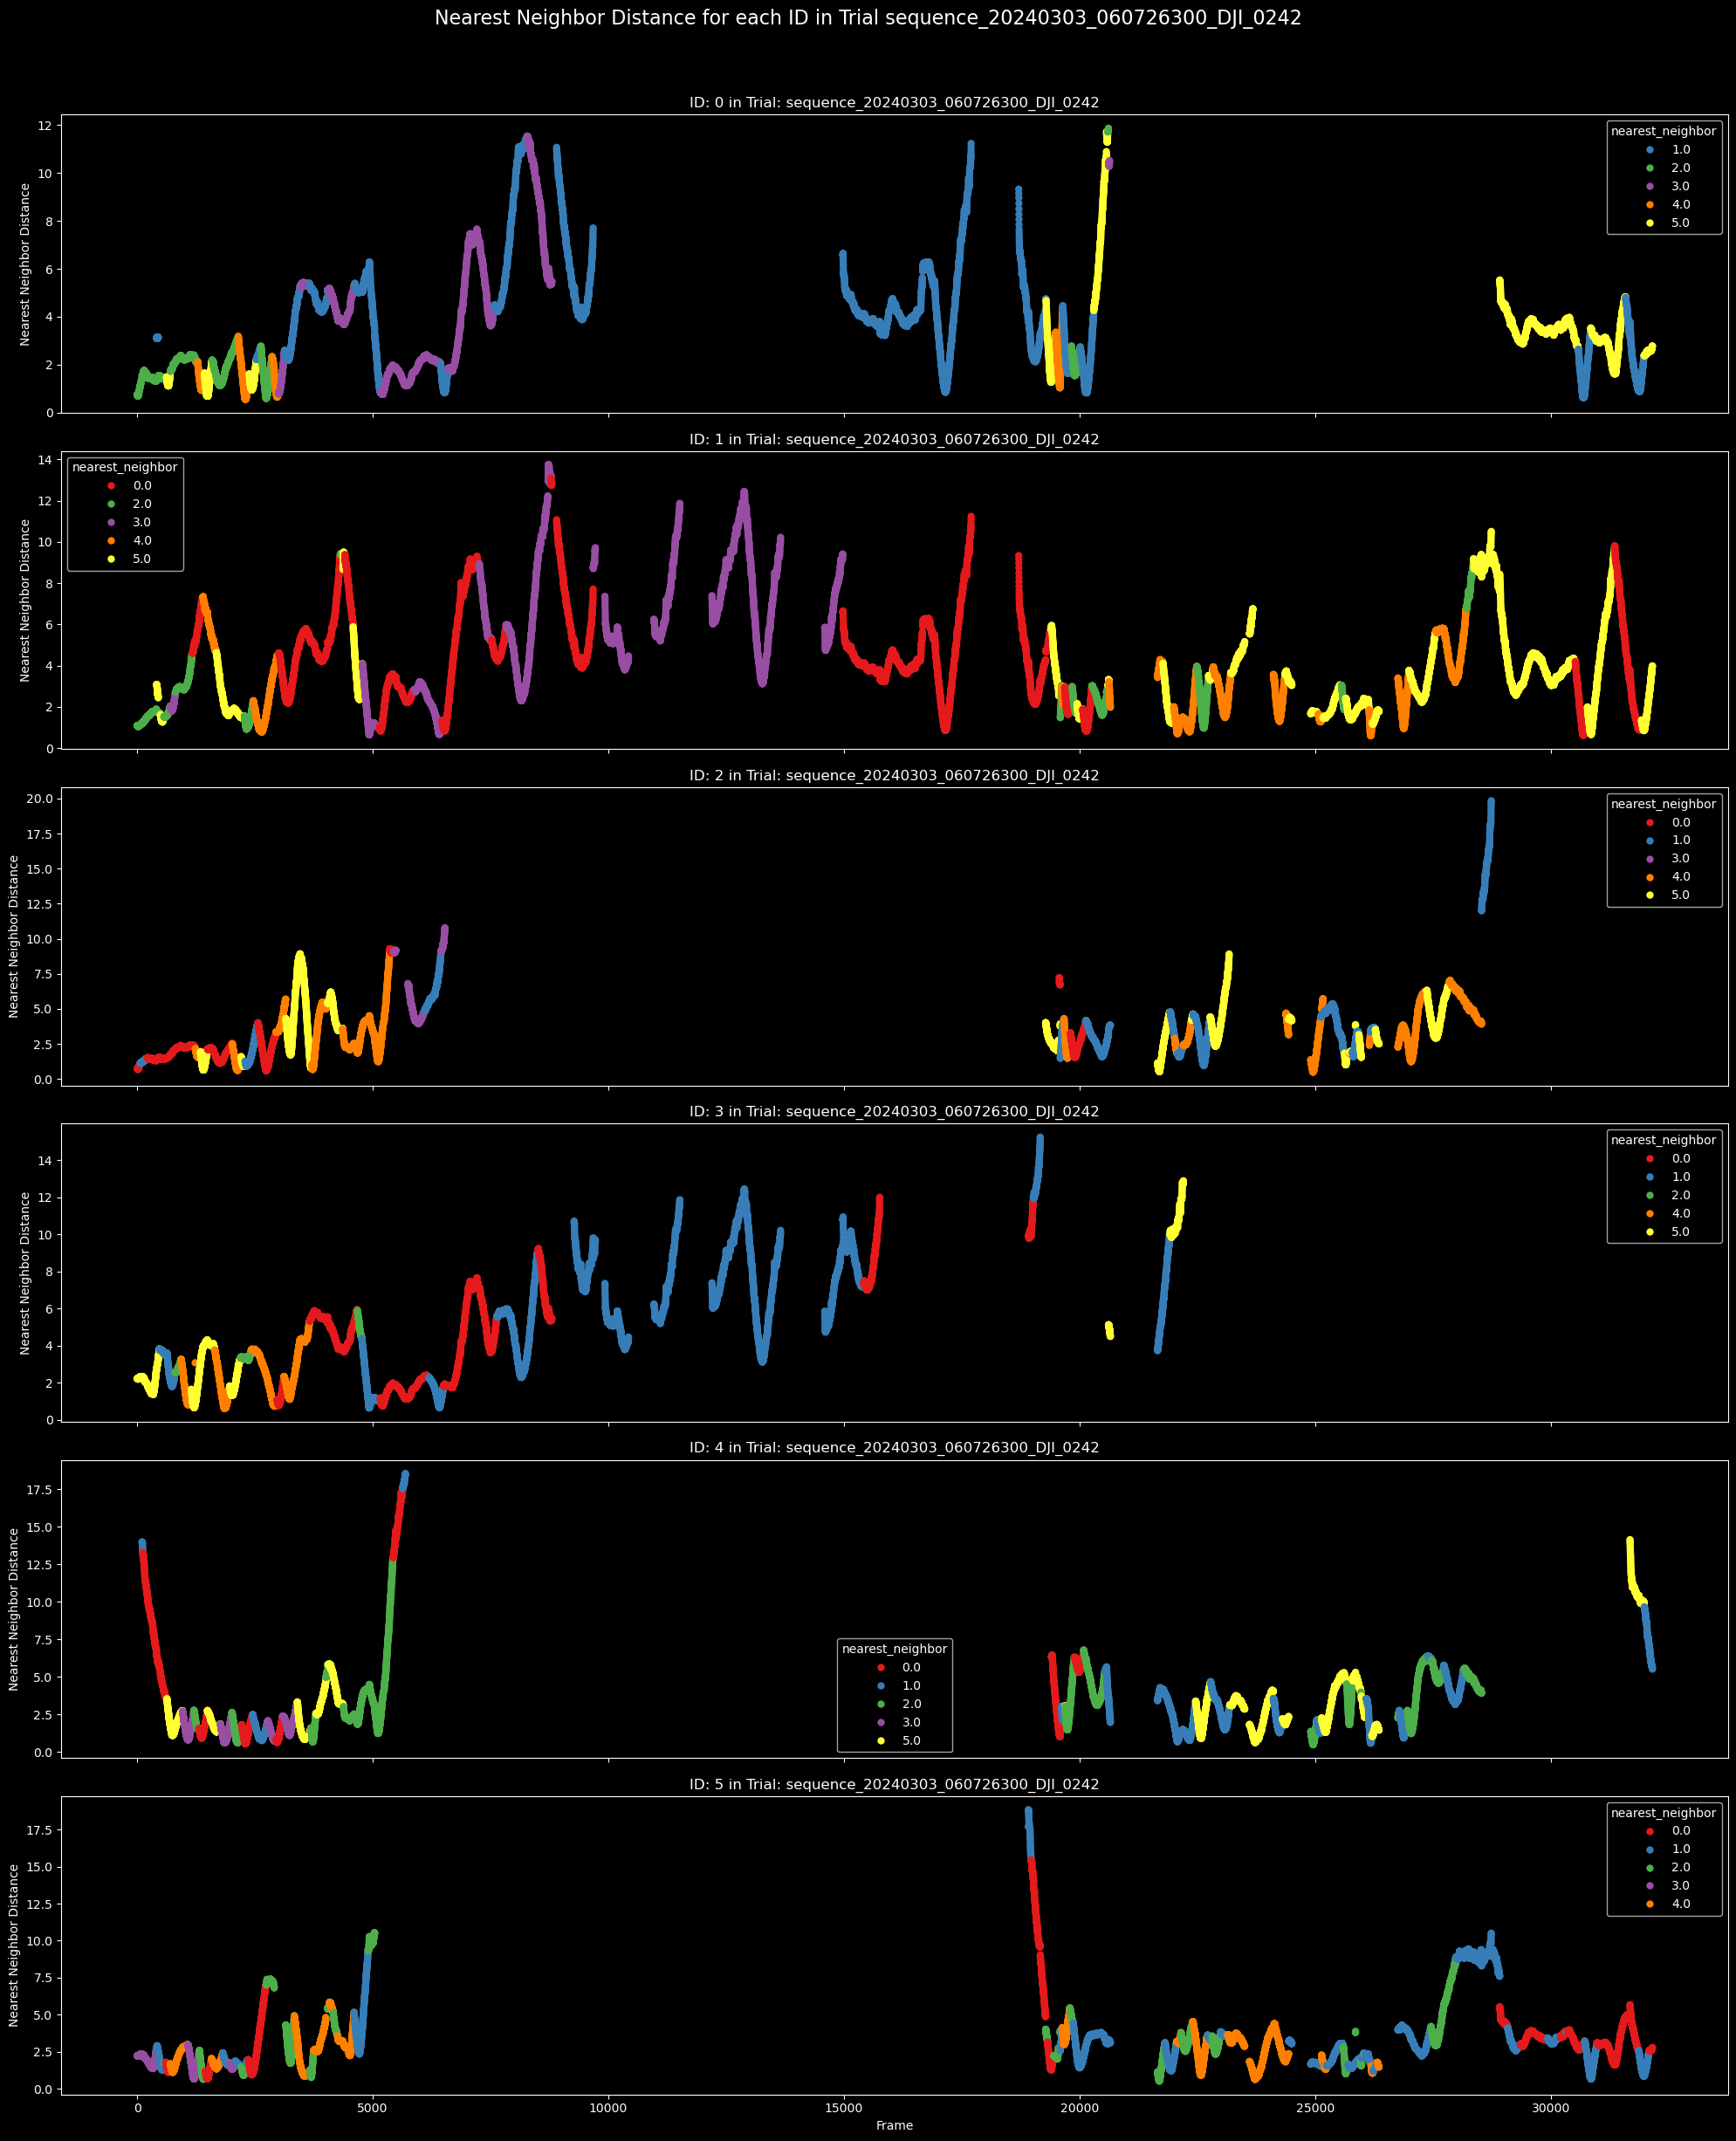

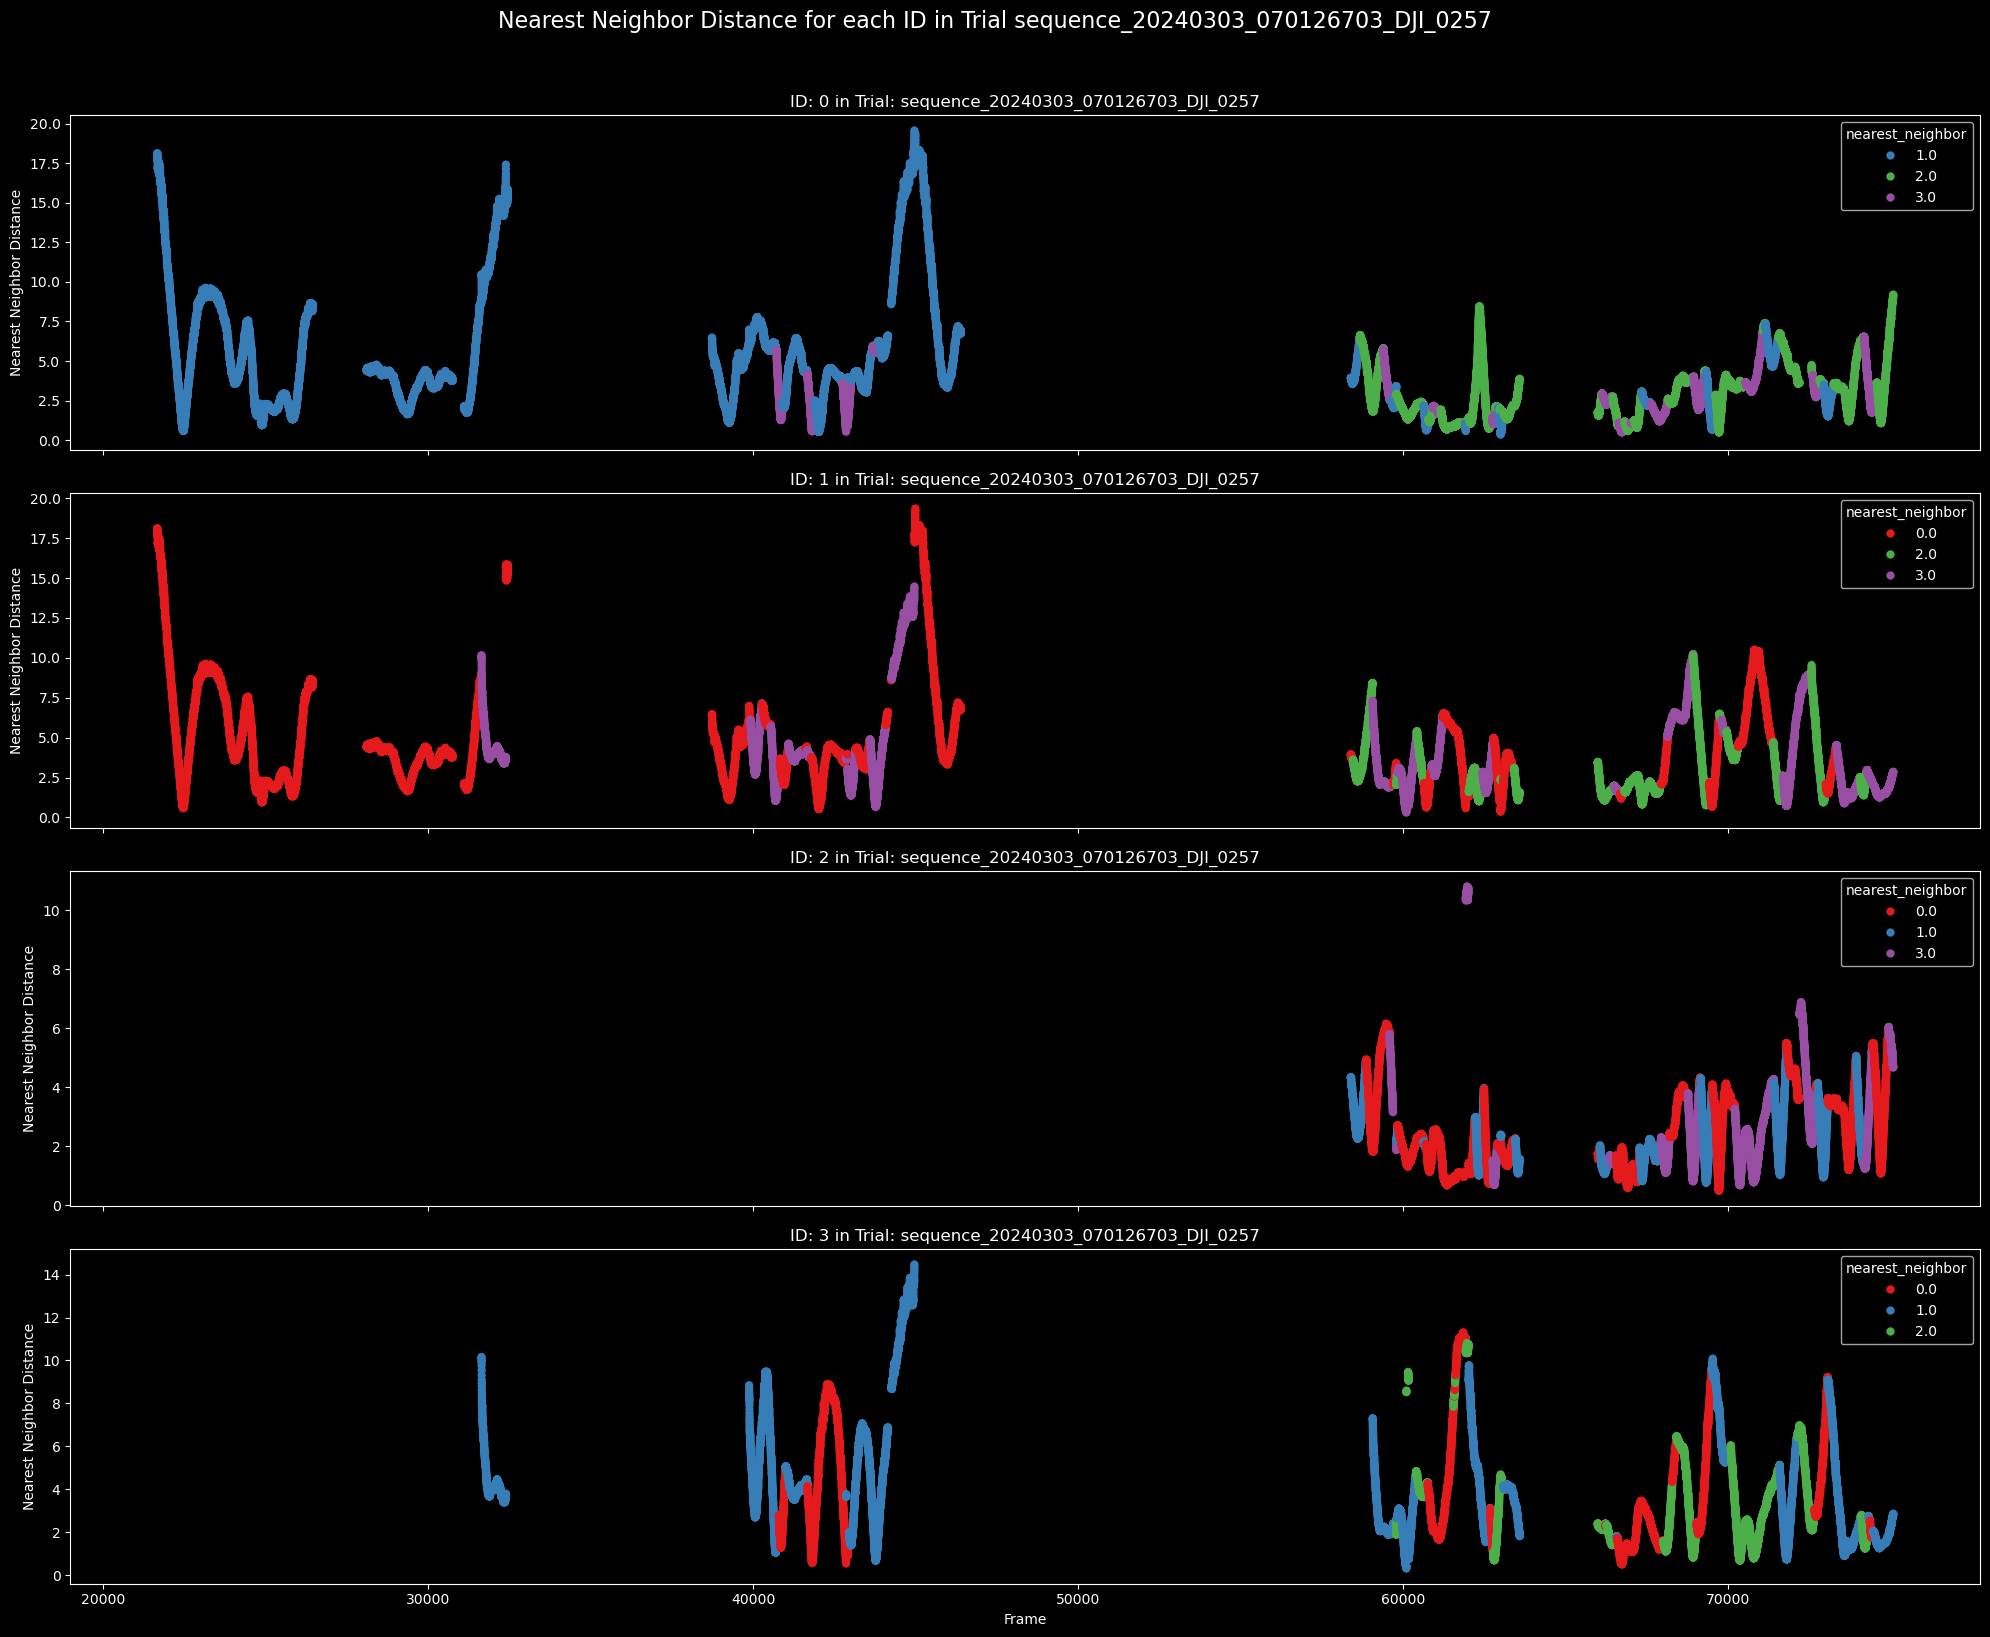

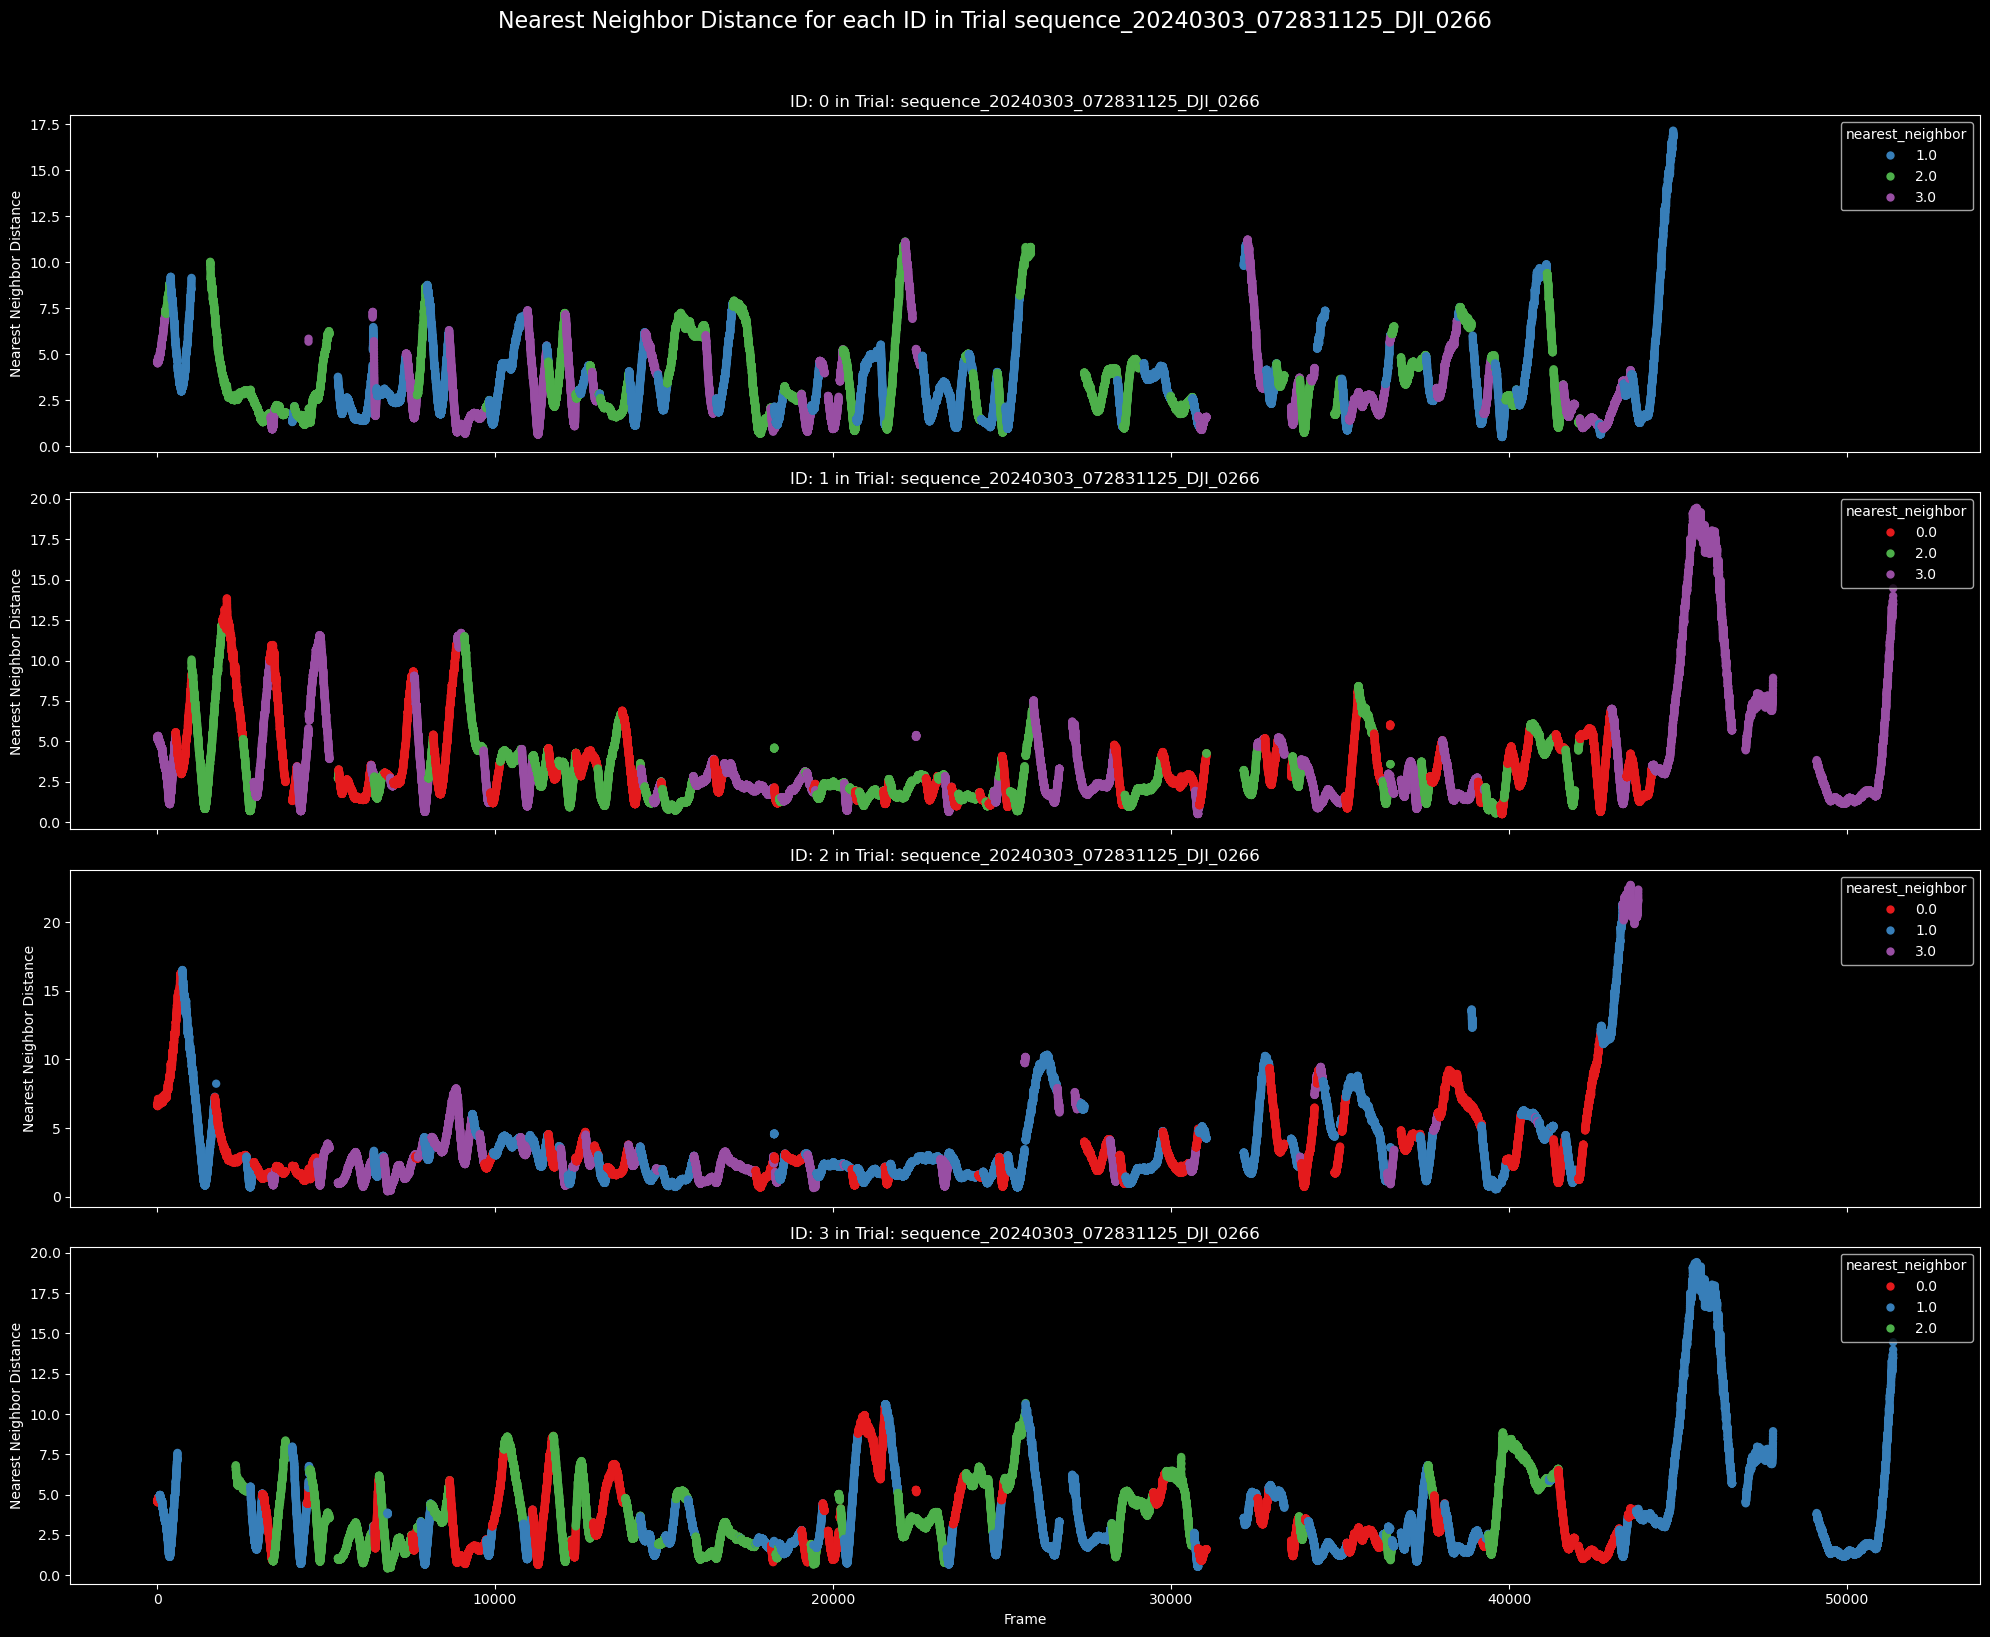

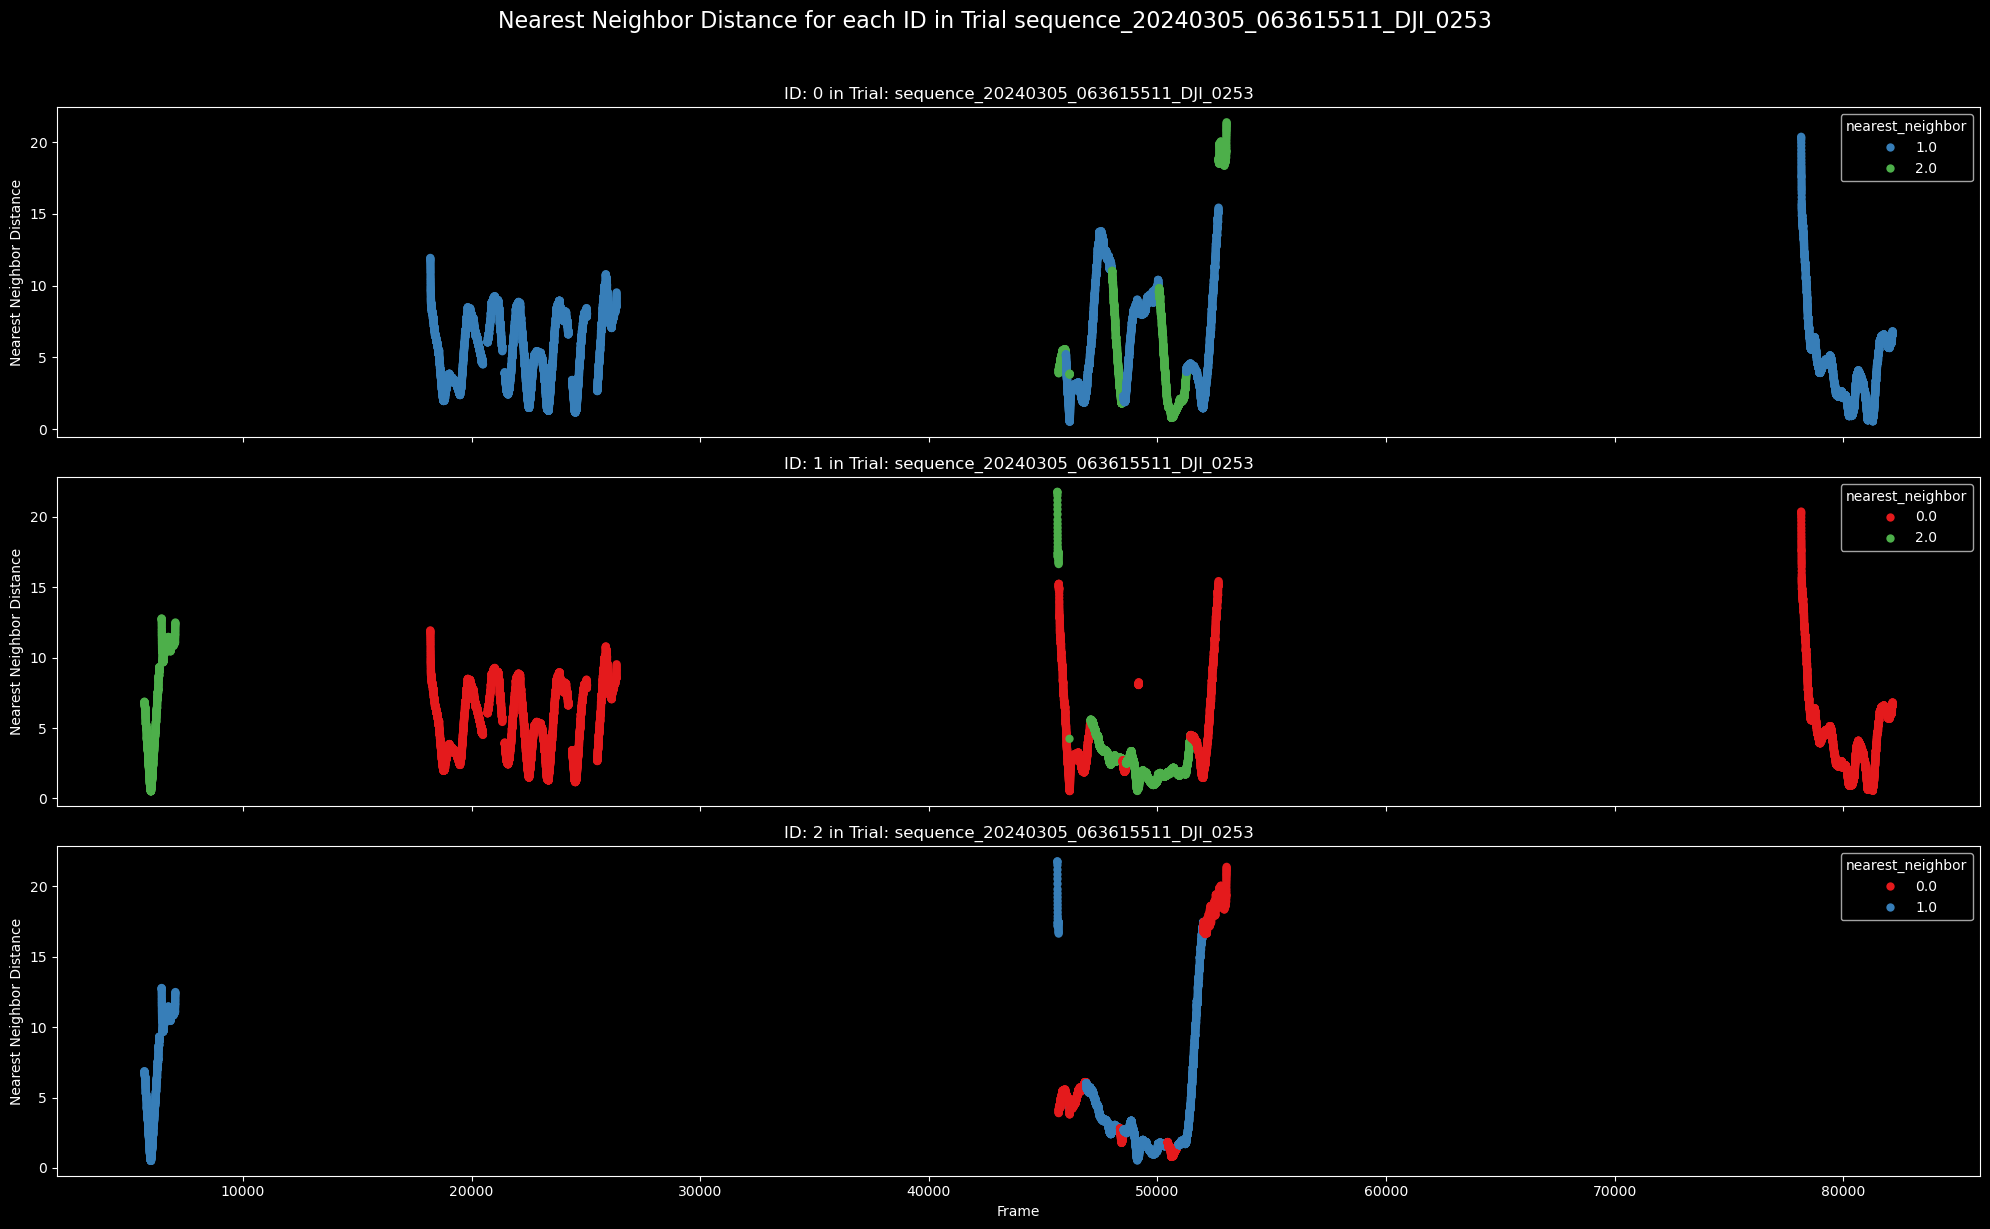

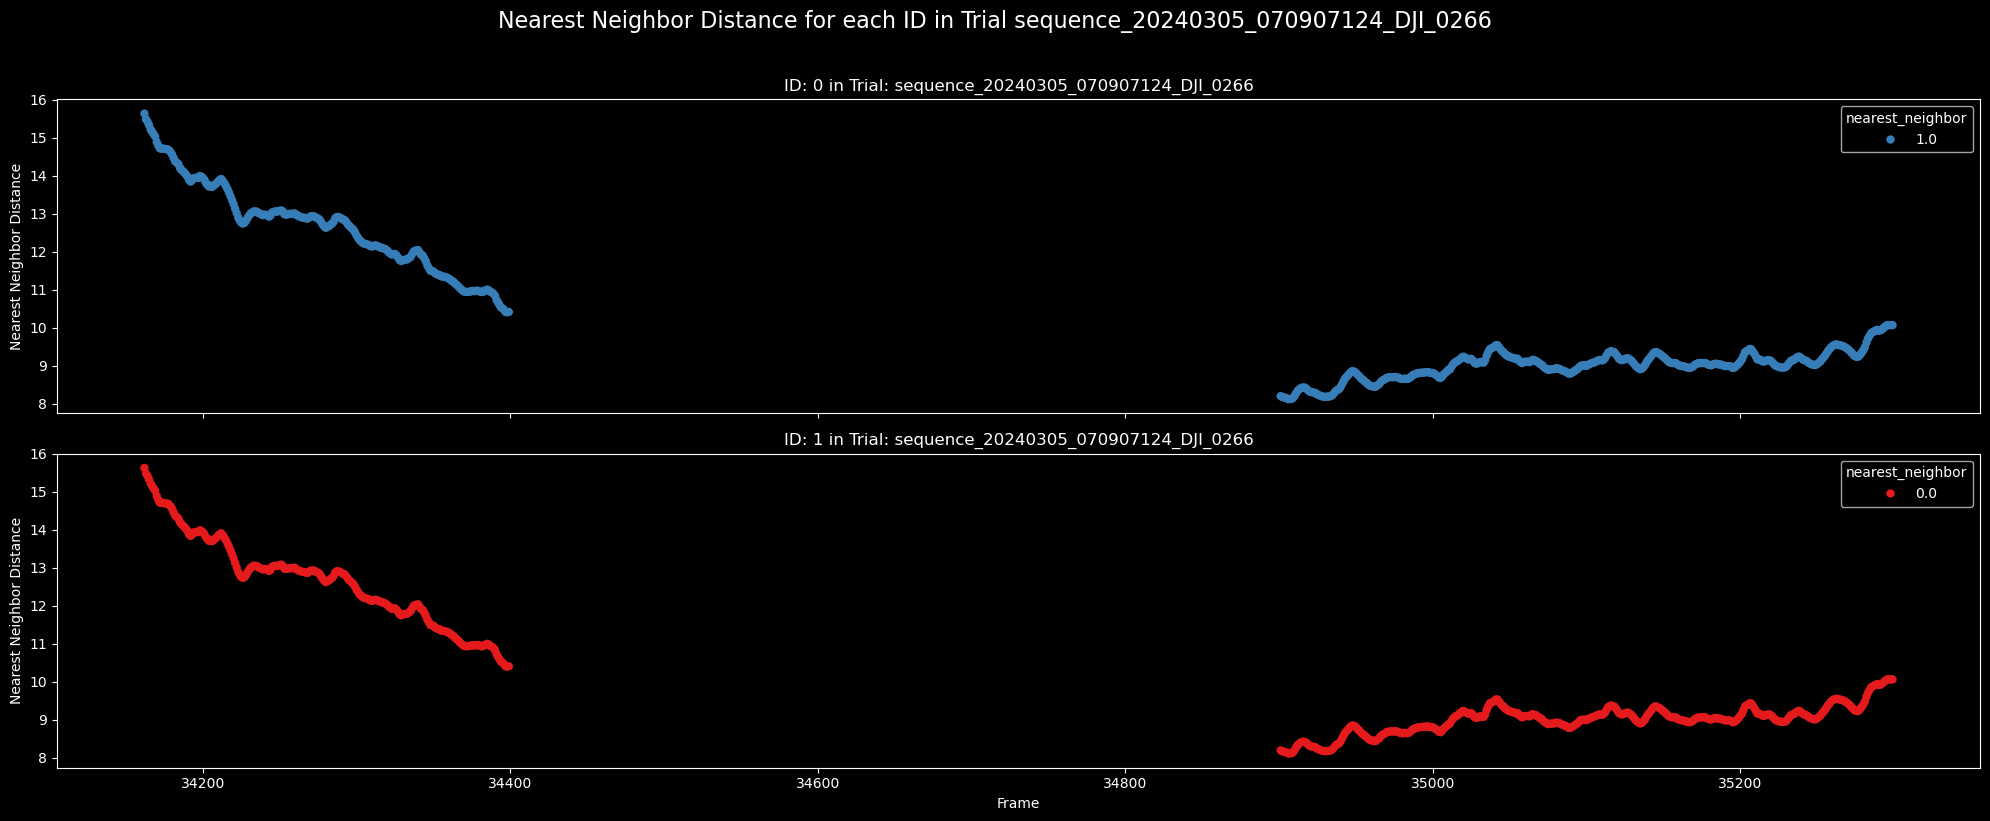

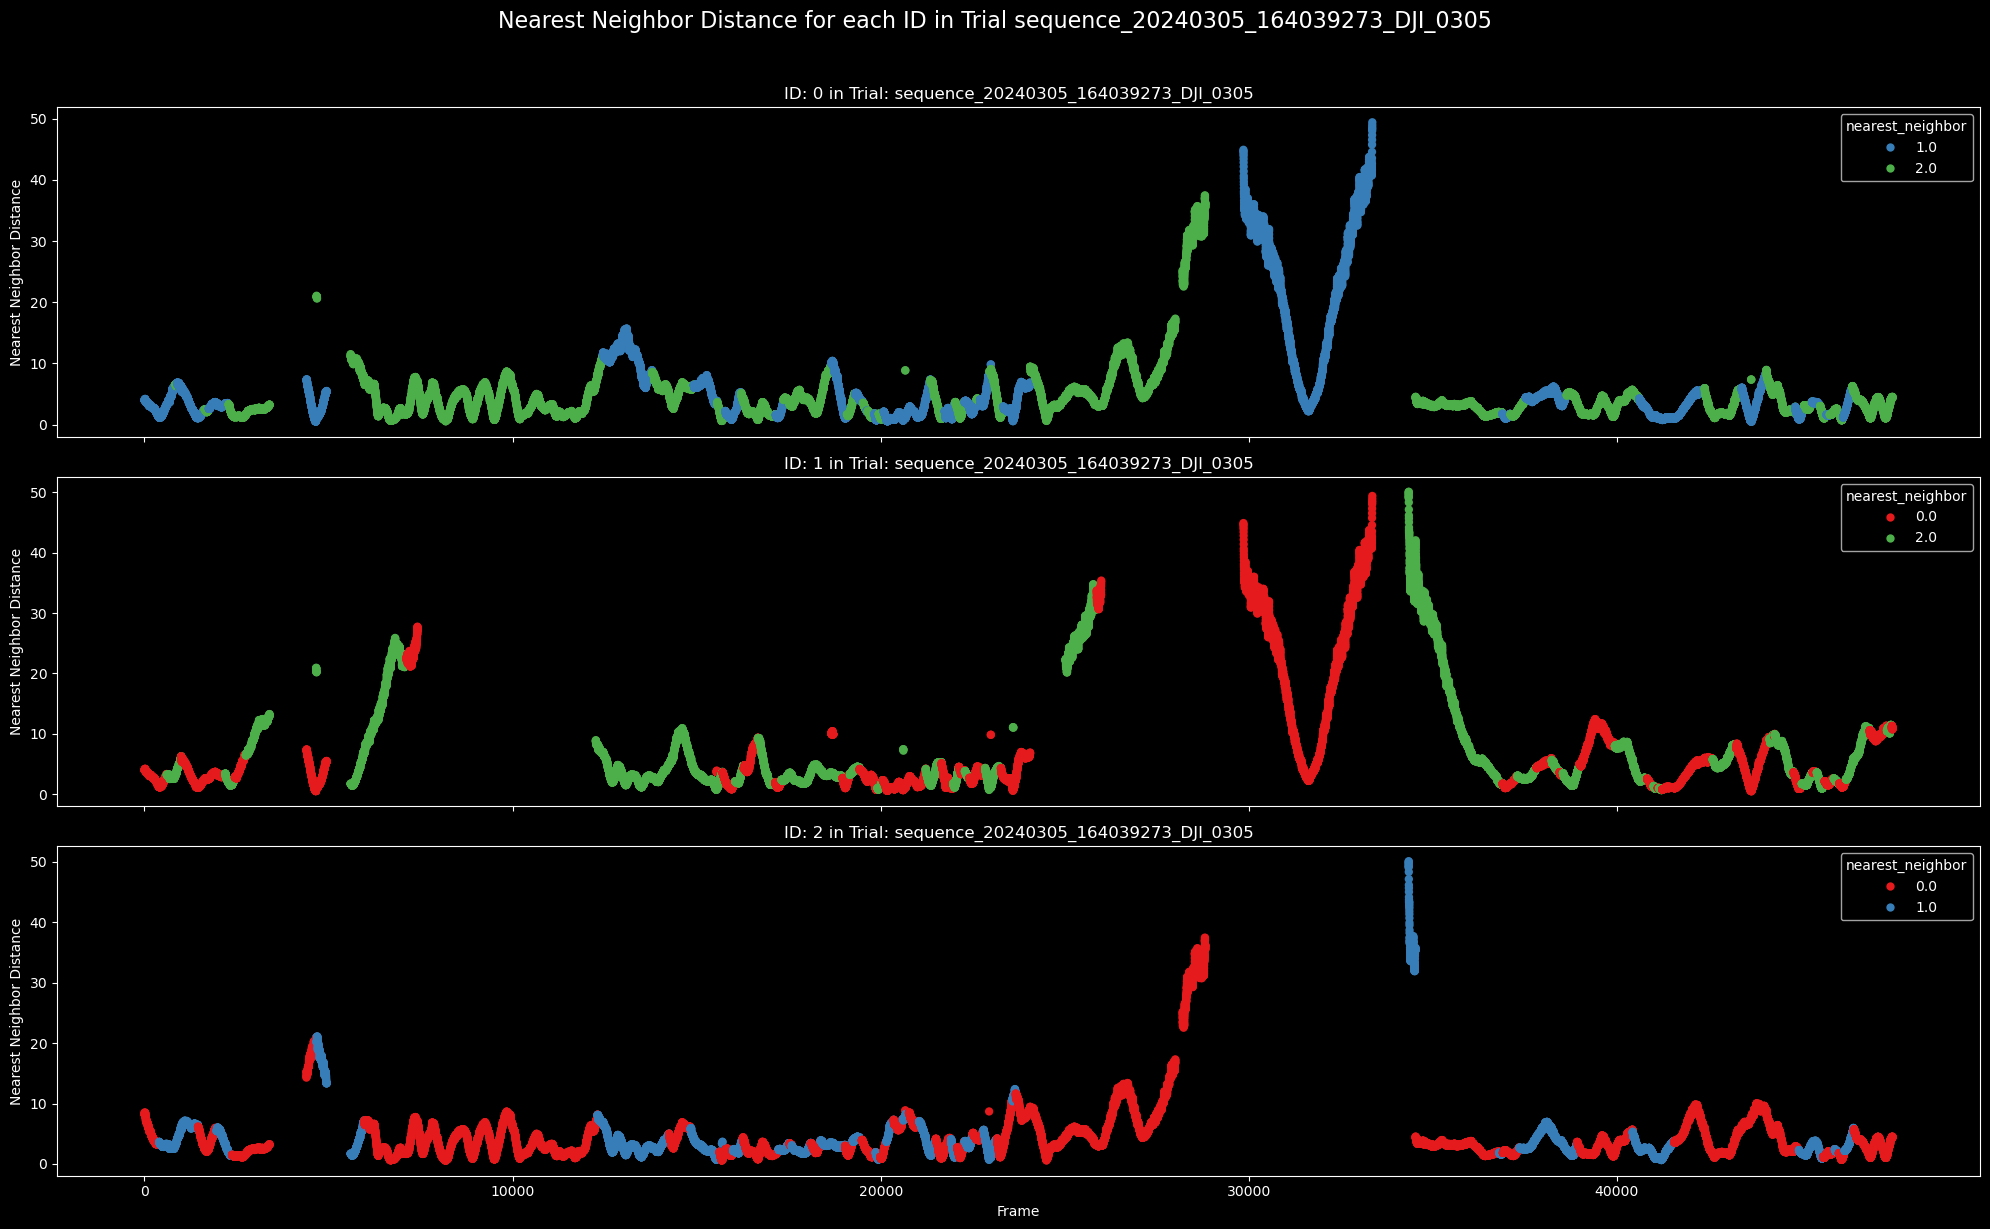

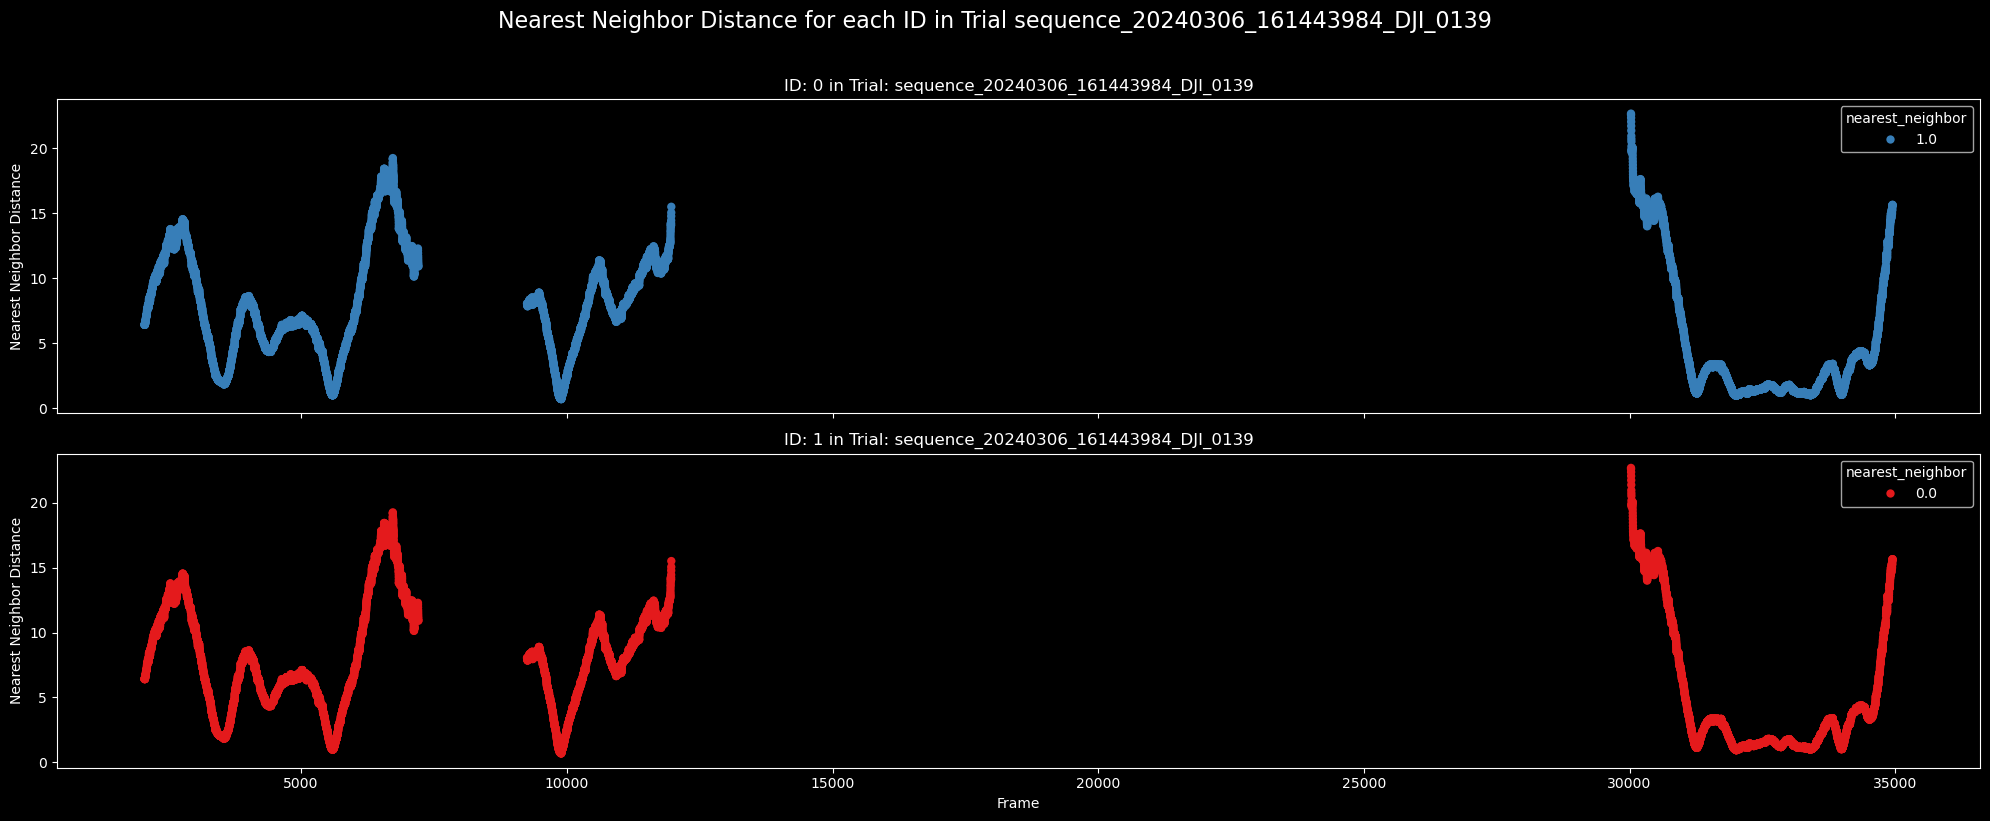

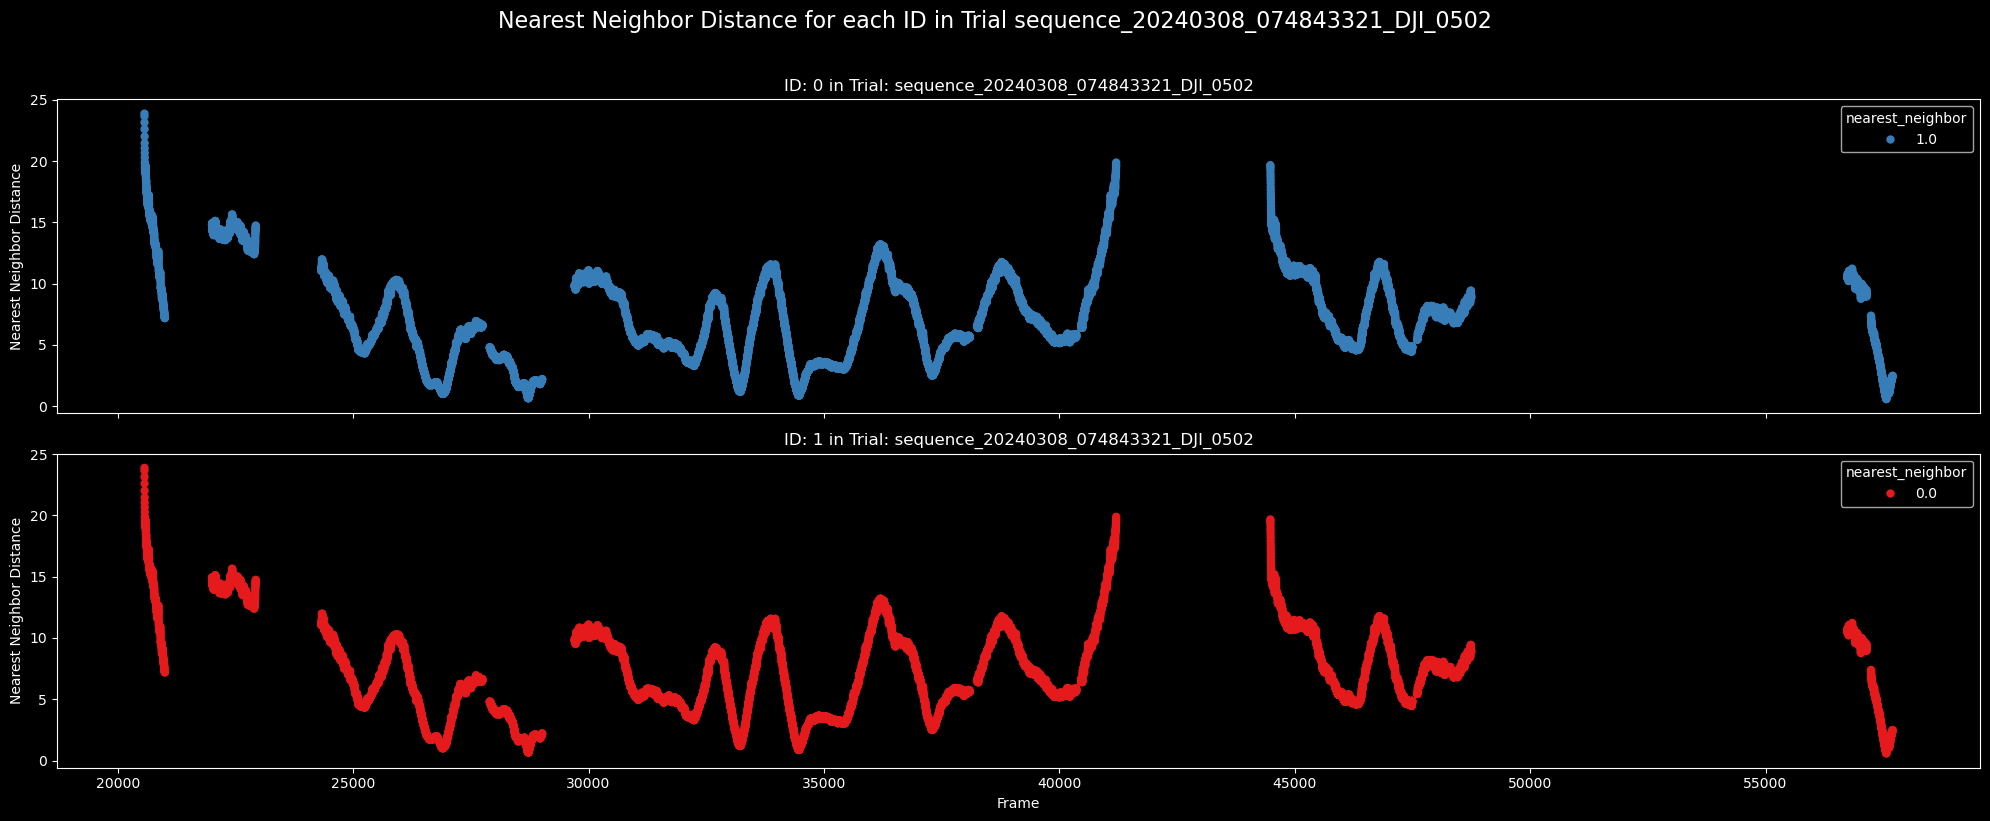

In [16]:
# Set up the color palette and color map
palette = sns.color_palette("Set1", n_colors=6)  
color_map = {i: palette[i] for i in range(len(palette))}

# Loop through each unique Trial and ID to create a plot for each
for trial in subset['Trial'].unique():
    trial_data = subset[subset['Trial'] == trial]  # Filter data for current trial
    unique_ids = trial_data['ID'].unique()  # Get all unique IDs in this trial

    # Create a subplot for each ID within this trial
    fig, axes = plt.subplots(len(unique_ids), 1, figsize=(20, 4 * len(unique_ids)), sharex=True)
    fig.suptitle(f"Nearest Neighbor Distance for each ID in Trial {trial}", y=1.02, fontsize=16)
    
    # If there’s only one ID, ensure axes are in list form to avoid errors
    if len(unique_ids) == 1:
        axes = [axes]

    # Plot for each ID in this trial
    for idx, (ax, unique_id) in enumerate(zip(axes, unique_ids)):
        # Filter out rows where nearest_neighbor is -1
        filtered_data = trial_data[(trial_data['ID'] == unique_id) & (trial_data['nearest_neighbor'] != -1)]

        # Plot the filtered data
        sns.scatterplot(
            ax=ax,
            x='frame',
            y='normalized_nnd',
            data=filtered_data,
            linewidth=0,
            hue='nearest_neighbor',
            palette=color_map
        )
        ax.set_title(f"ID: {unique_id} in Trial: {trial}")
        ax.set_ylabel("Nearest Neighbor Distance")
        ax.set_xlabel("Frame")
    
    plt.tight_layout()
    plt.show()


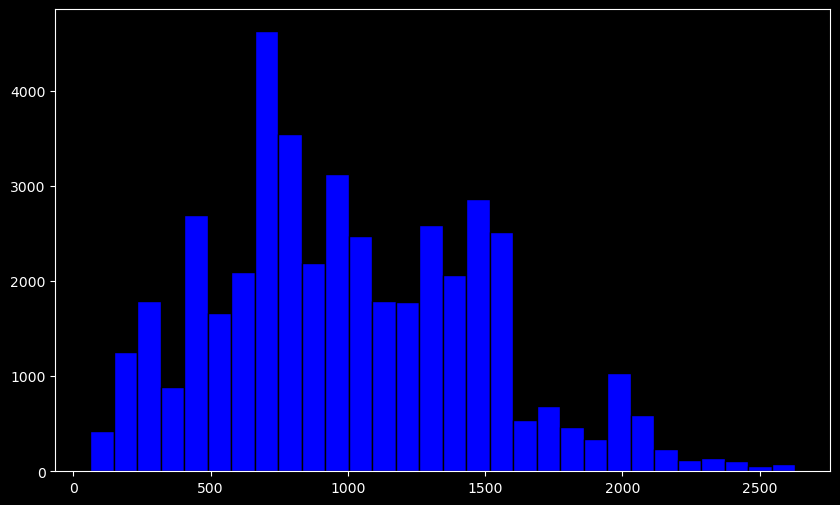

In [20]:
# Filter out any infinite or NaN values from mindist
filtered_mindist = mindist[np.isfinite(mindist)]

# Create a histogram for the filtered nearest neighbor distances
plt.figure(figsize=(10, 6))
plt.hist(filtered_mindist, bins=30, color='blue', edgecolor='black')
plt.show()


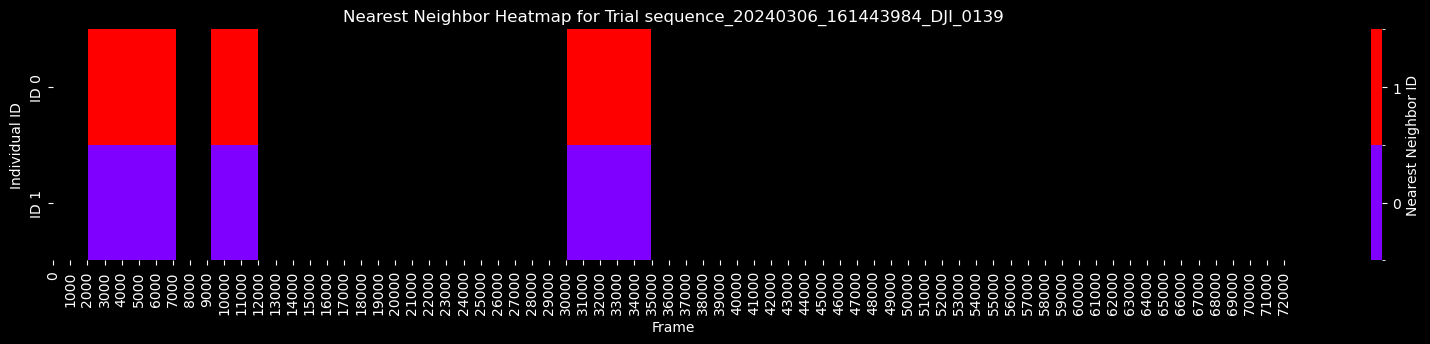

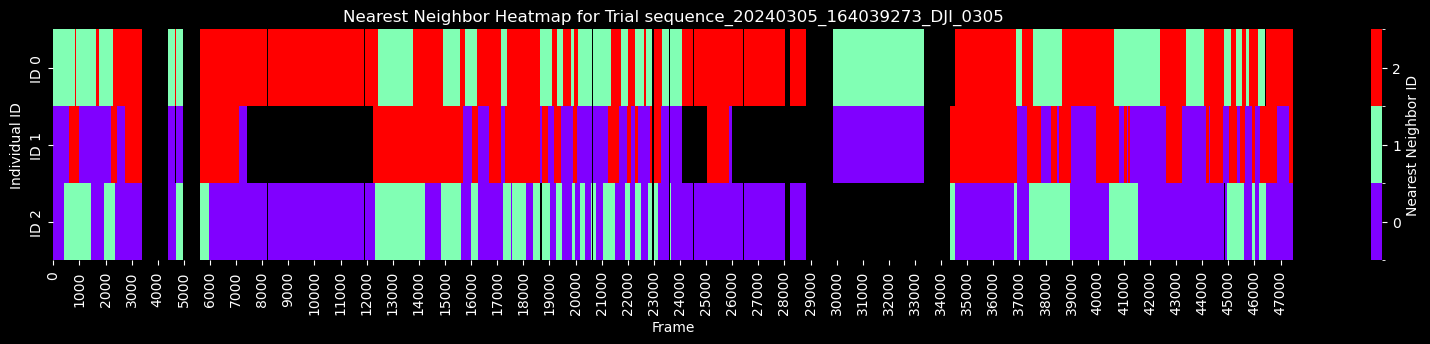

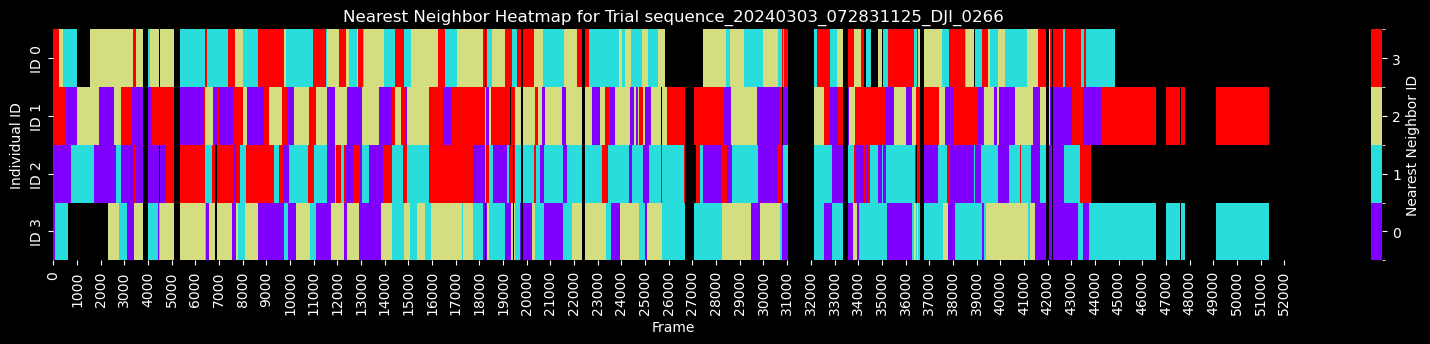

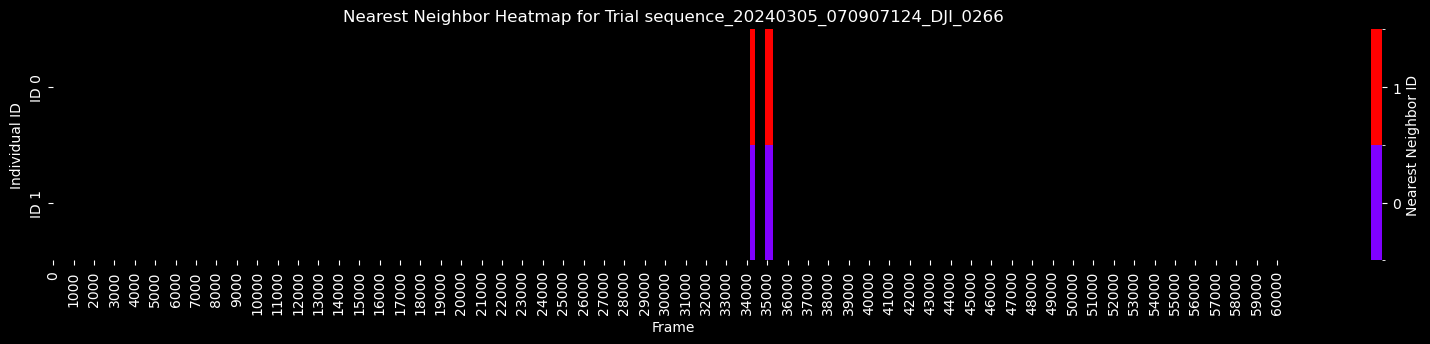

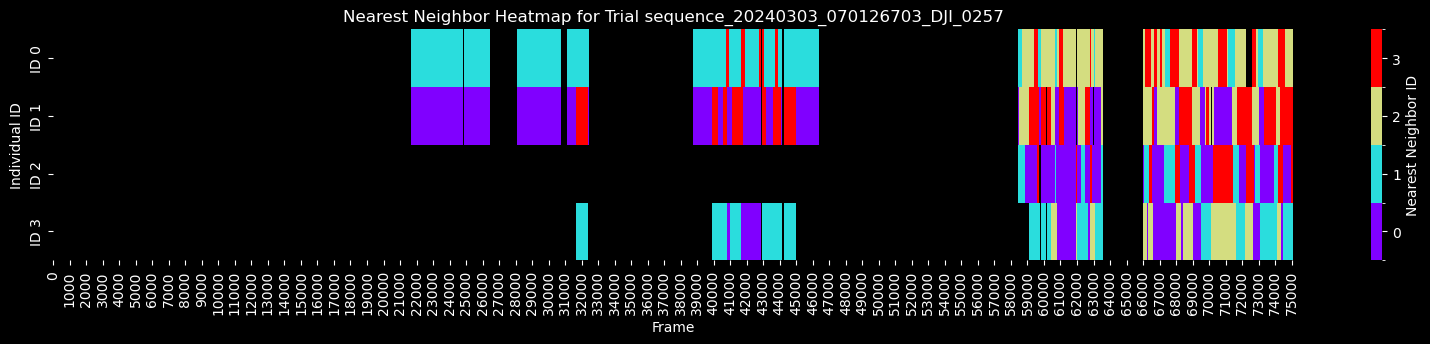

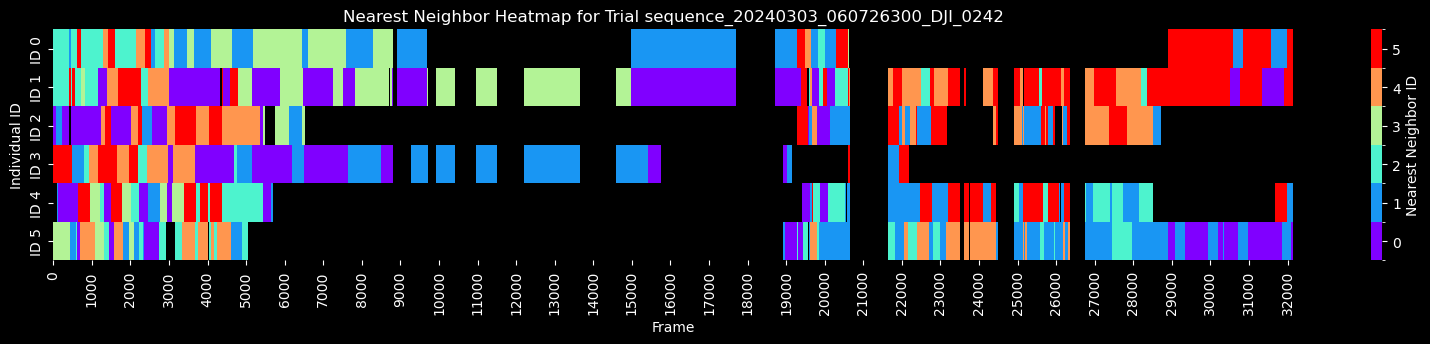

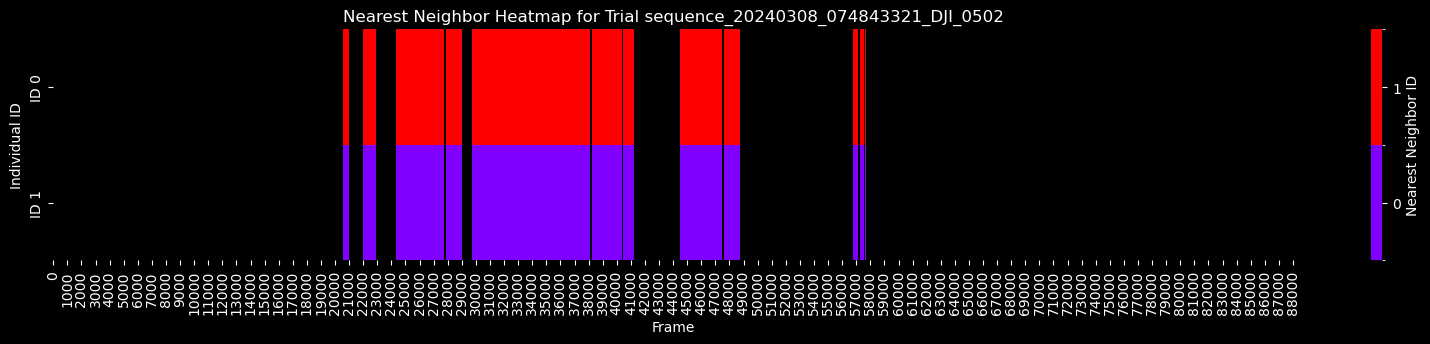

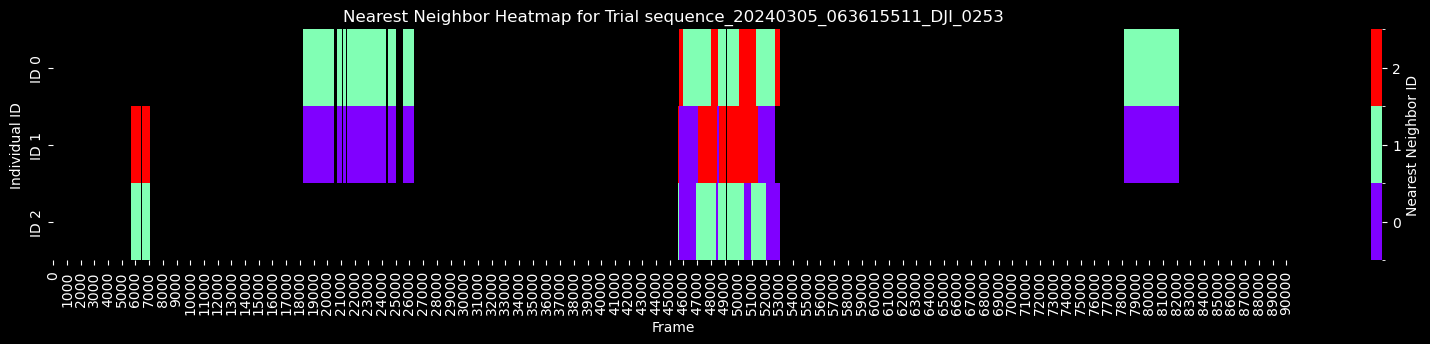

In [17]:
import matplotlib.colors as mcolors
# Define discrete color levels
for trial in df_nndist['Trial'].unique():
    # Filter data for the current trial
    trial_data = df_nndist[df_nndist['Trial'] == trial]
    
    # Get unique IDs and frames in the current trial
    unique_ids = trial_data['ID'].unique()
    maxframe = trial_data['frame'].max() + 1  # Assuming frame indexing starts from 0
    
    # Initialize a matrix for nearest neighbors with NaN to handle missing values
    heatmap_data = np.full((len(unique_ids), maxframe), np.nan)

    # Map each ID to a row index in the heatmap matrix
    id_to_index = {id_val: idx for idx, id_val in enumerate(unique_ids)}

    # Populate the heatmap matrix with nearest neighbor IDs
    for _, row in trial_data.iterrows():
        row_idx = id_to_index[row['ID']]
        frame_idx = int(row['frame'])
        heatmap_data[row_idx, frame_idx] = row['nearest_neighbor']

    # Define discrete color levels
    num_levels = len(np.unique(heatmap_data[~np.isnan(heatmap_data)]))  # Unique values excluding NaN
    colors = plt.cm.rainbow(np.linspace(0, 1, num_levels))  # Generate discrete colors
    cmap = mcolors.ListedColormap(colors)  # Create a colormap
    bounds = np.arange(num_levels + 1) - 0.5  # Define bin boundaries
    norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize color mapping

    # Plot the heatmap for the current trial
    '''Add an evident mark for end of segment '''
    plt.figure(figsize=(20, 3))
    ax = sns.heatmap(heatmap_data, cmap=cmap, cbar=True, norm=norm,
                     xticklabels=1000,  
                     yticklabels=[f'ID {id_val}' for id_val in unique_ids])
    
    # Adjust the colorbar
    cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
    cbar.set_ticks(np.arange(num_levels))  # Set tick positions
    cbar.set_ticklabels(np.arange(num_levels))  # Set tick labels
    cbar.set_label("Nearest Neighbor ID")

    plt.title(f"Nearest Neighbor Heatmap for Trial {trial}")
    plt.xlabel("Frame")
    plt.ylabel("Individual ID")
    plt.show()


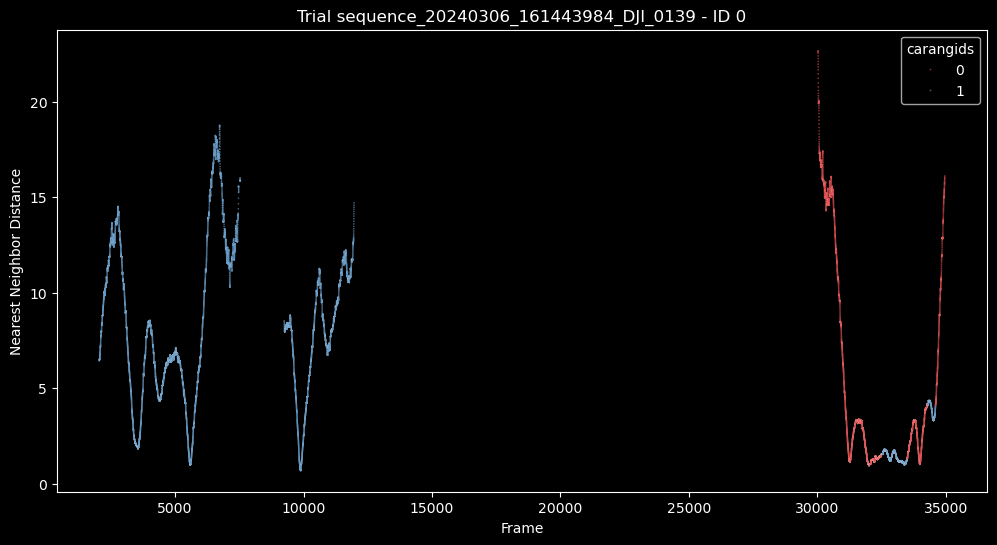

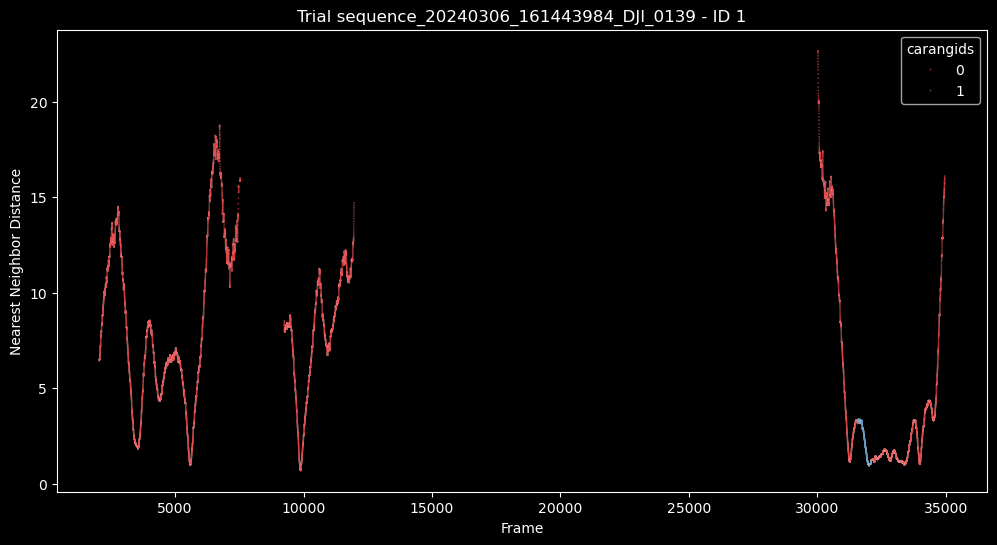

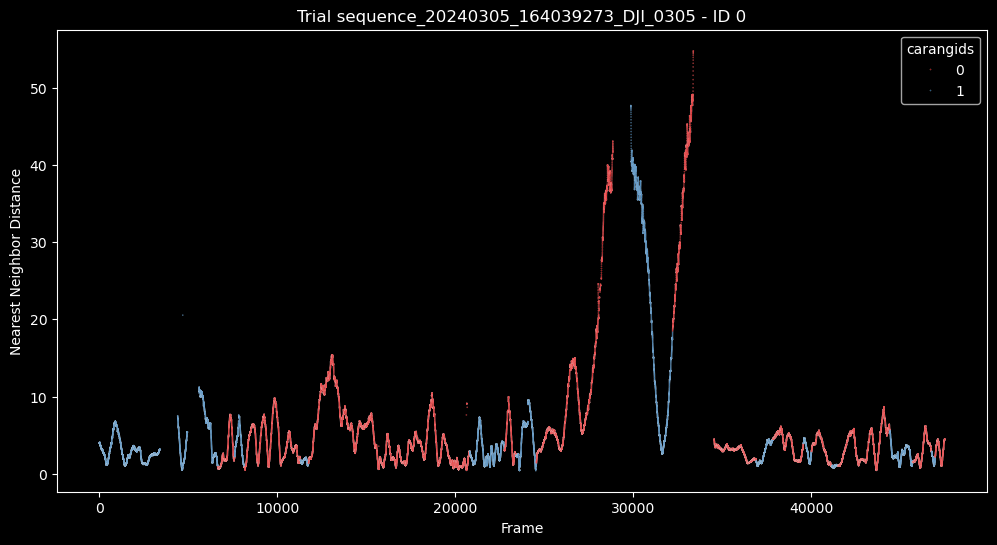

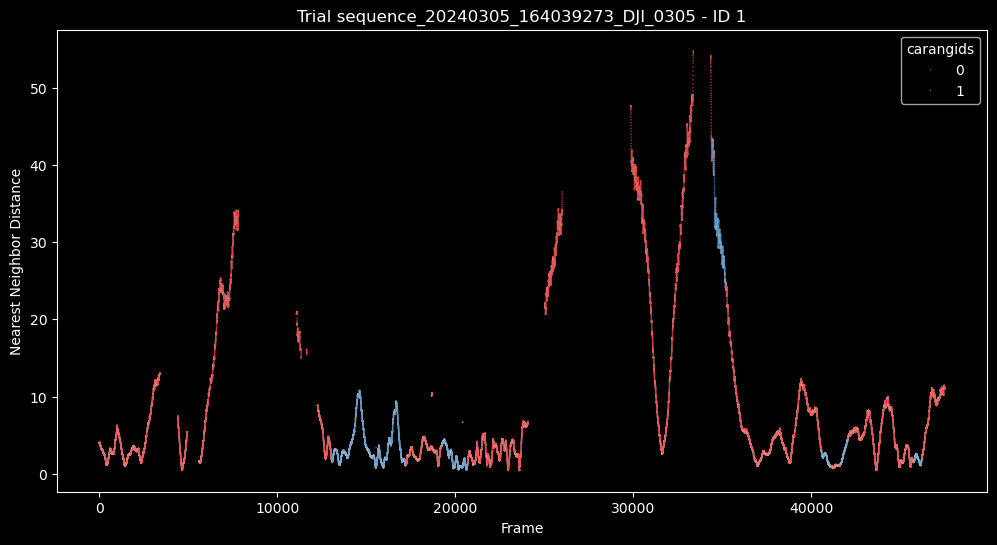

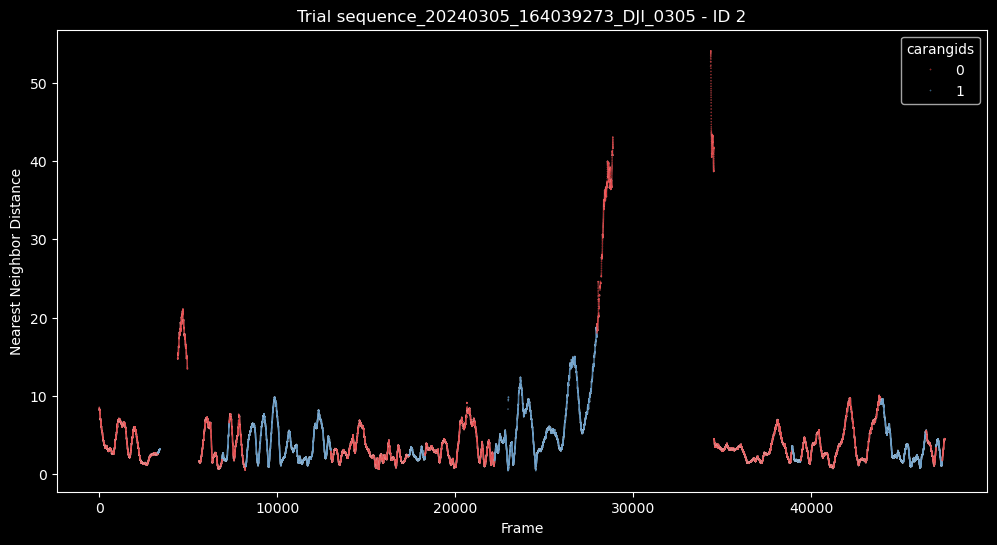

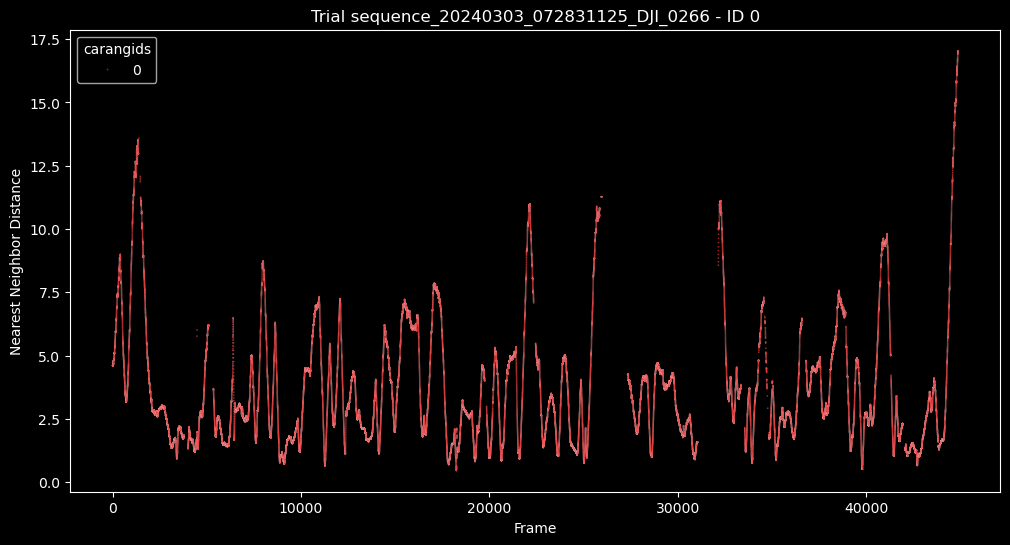

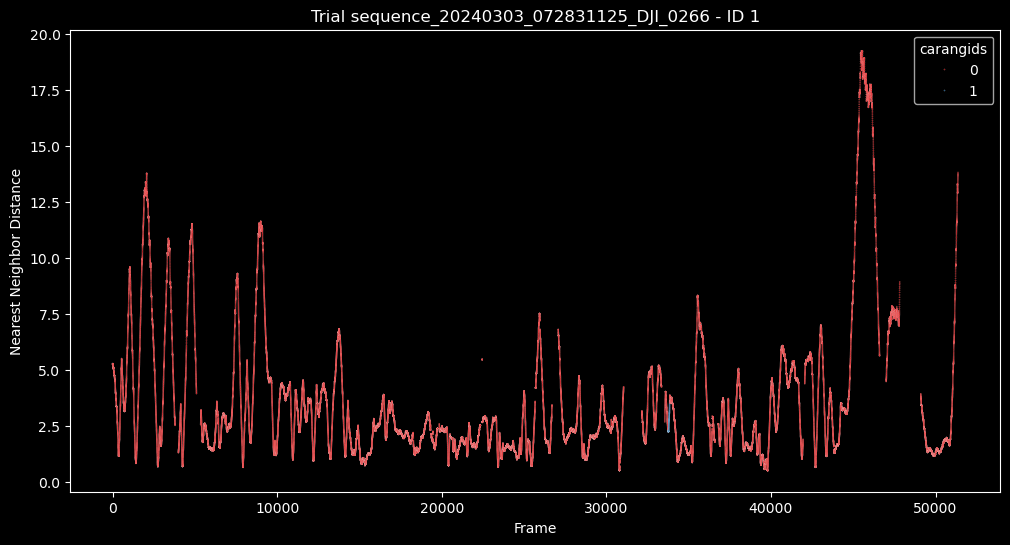

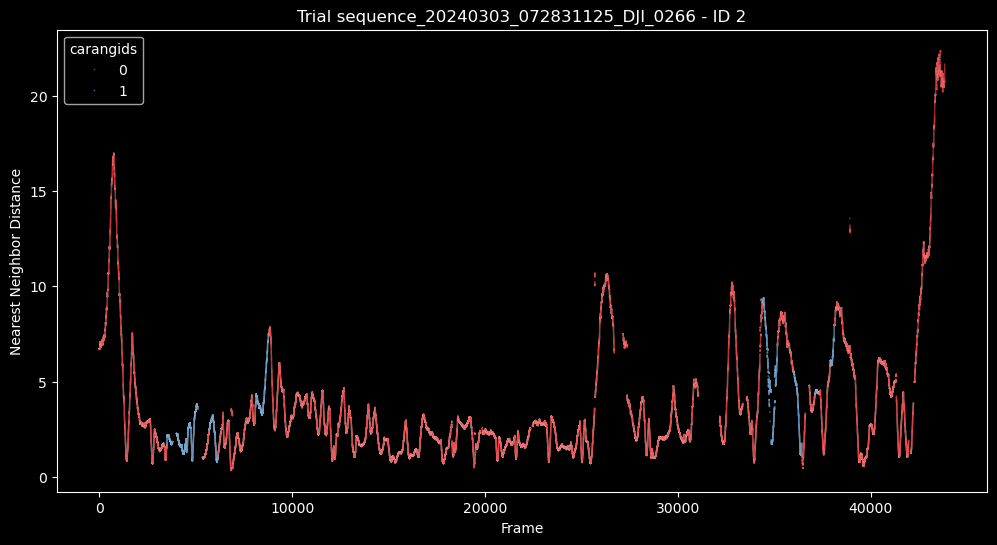

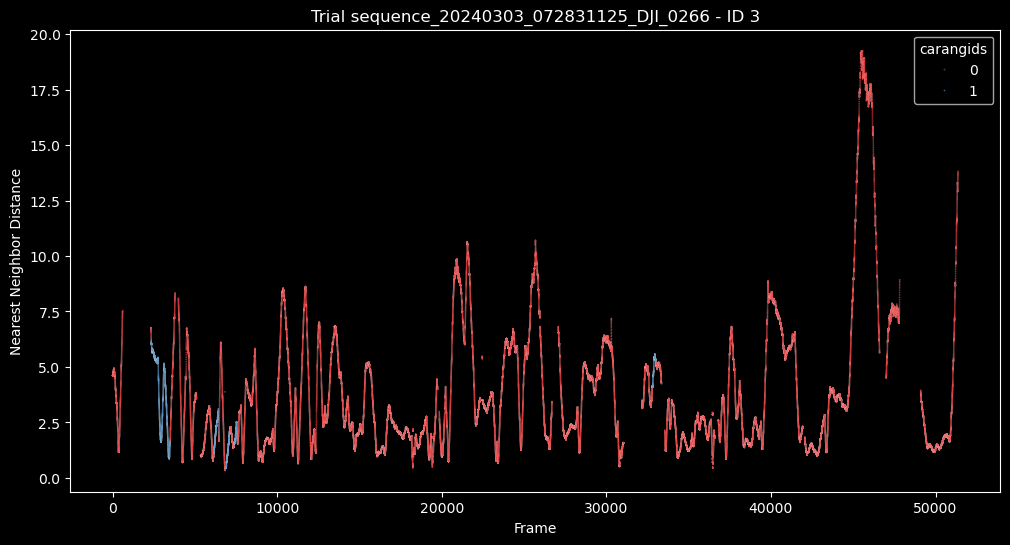

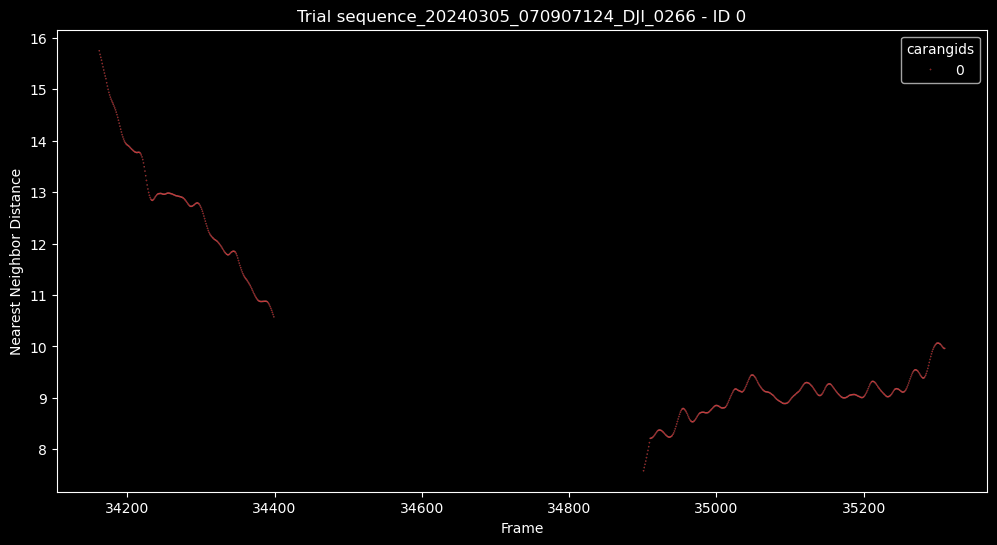

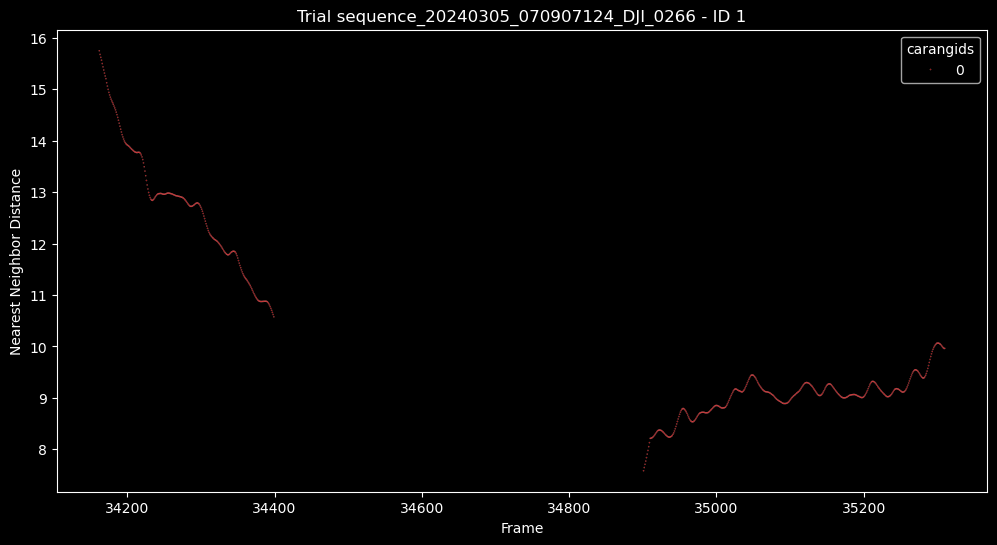

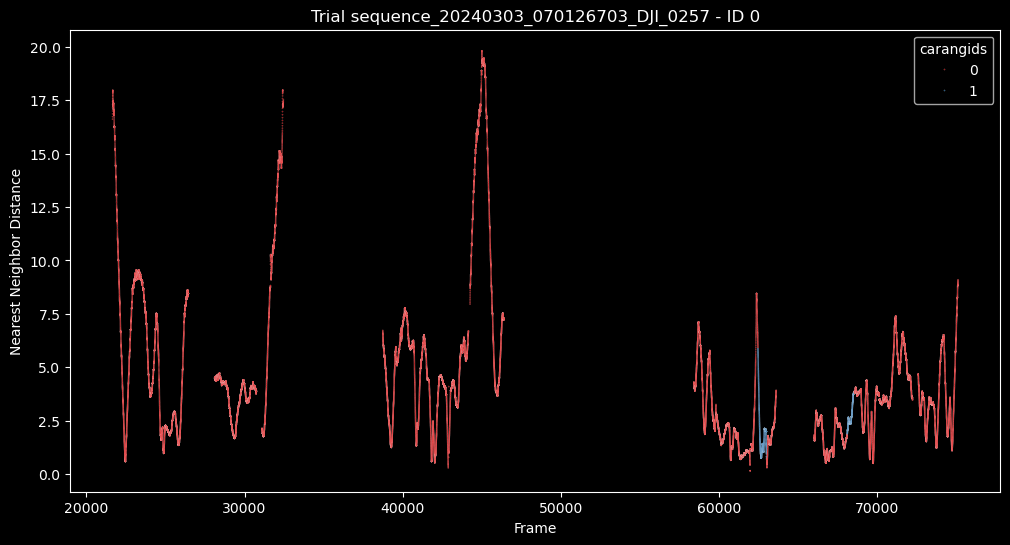

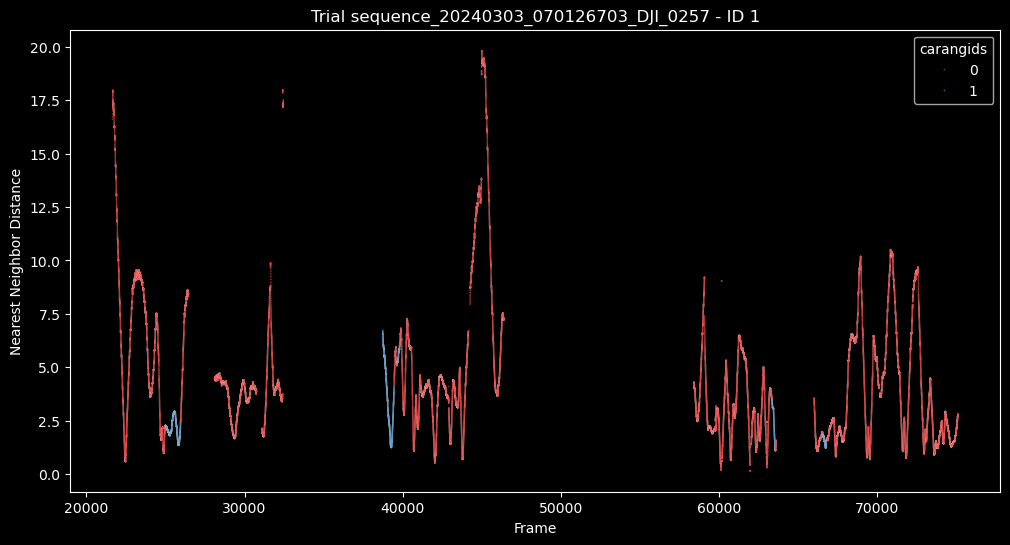

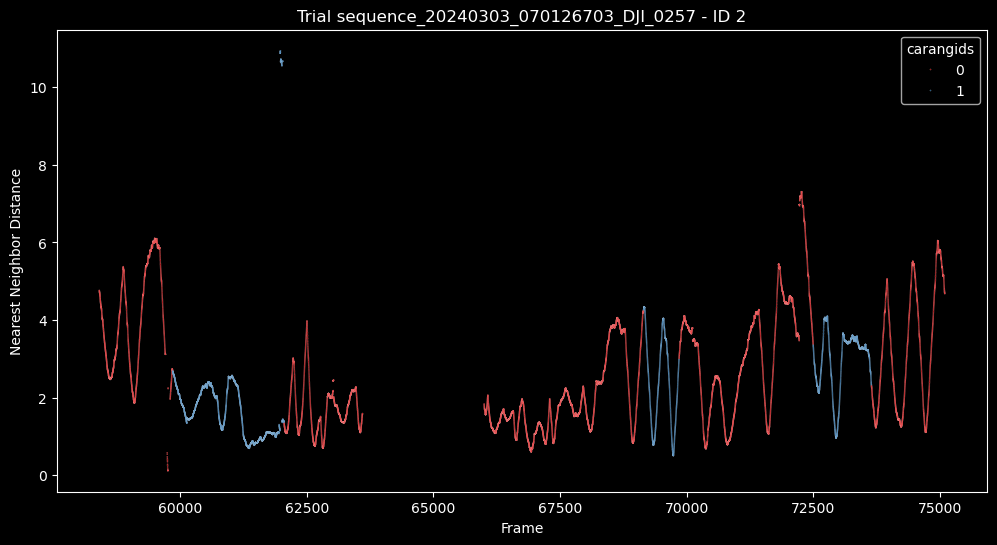

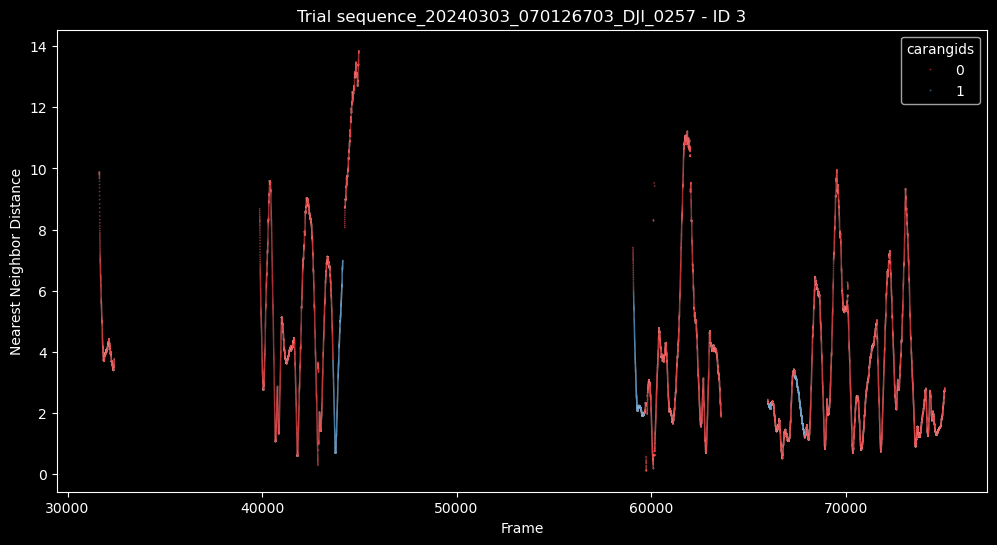

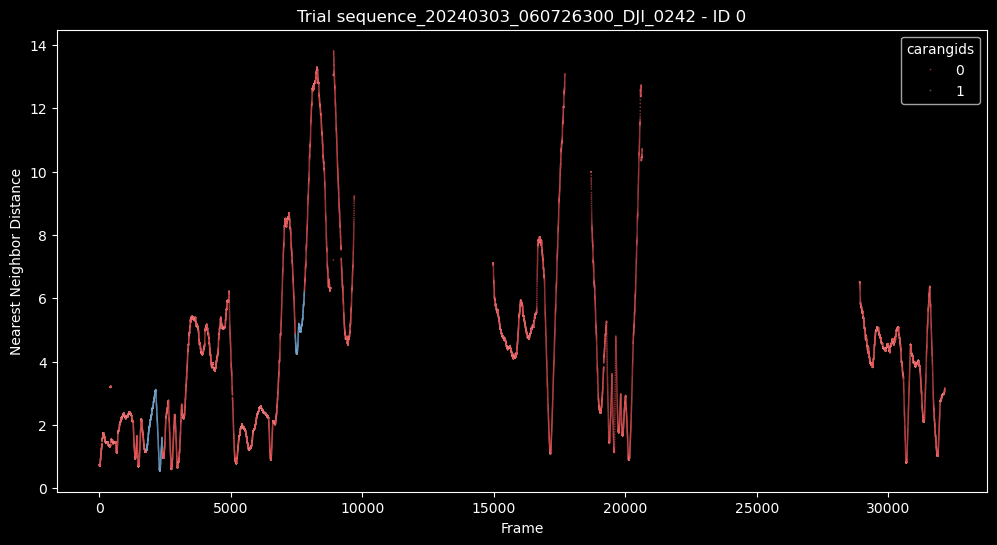

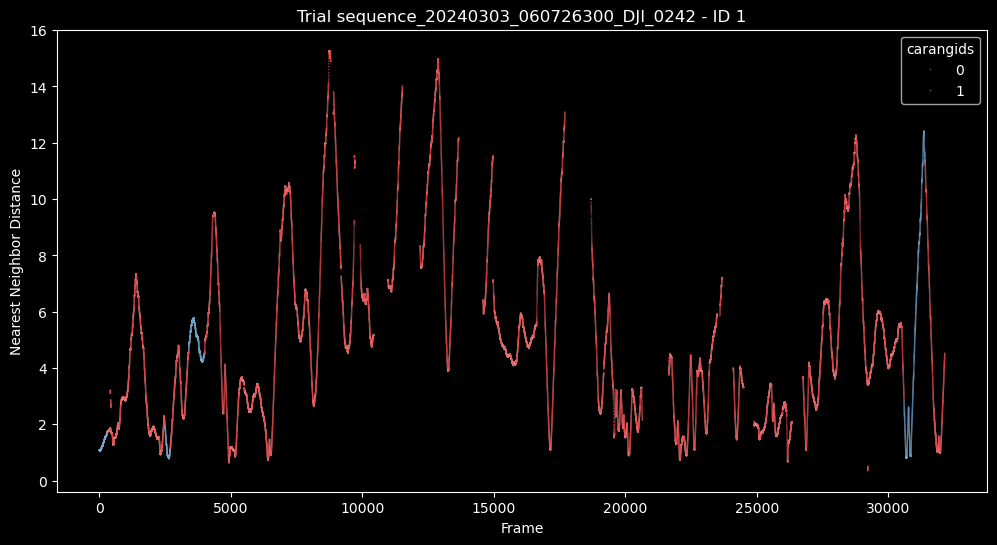

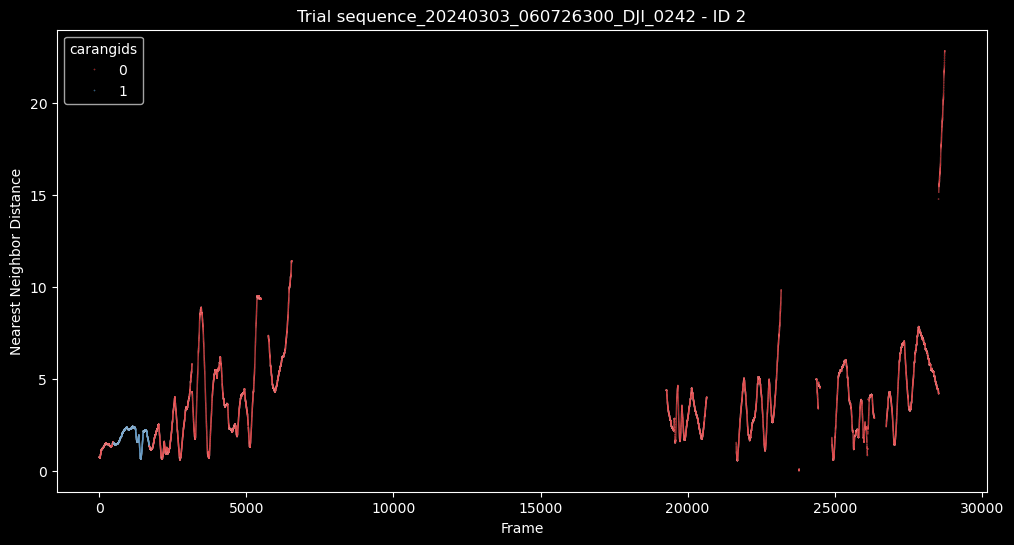

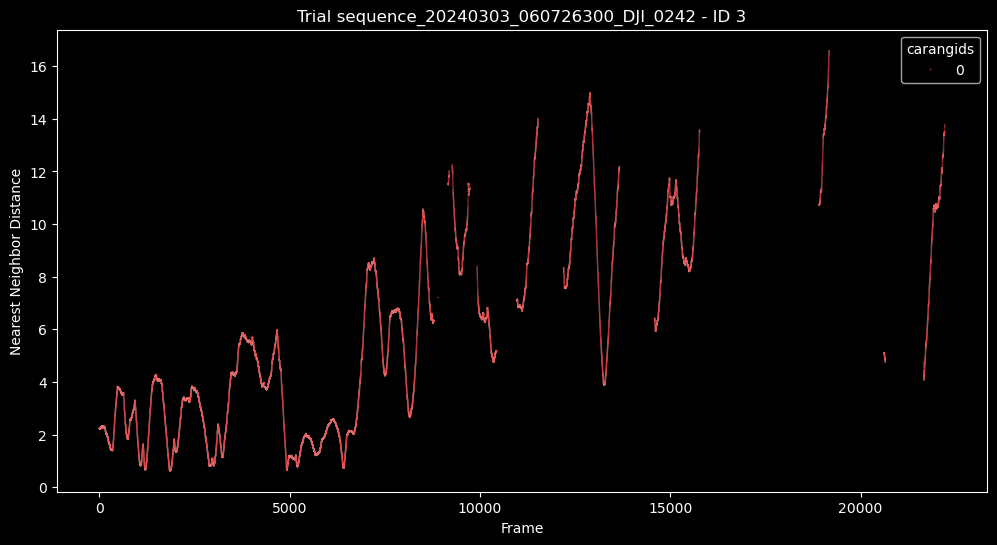

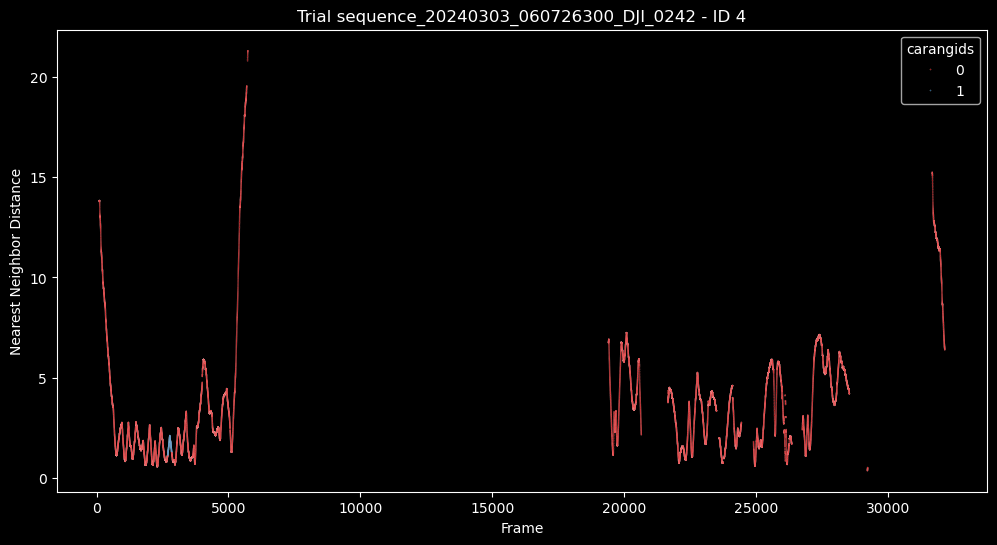

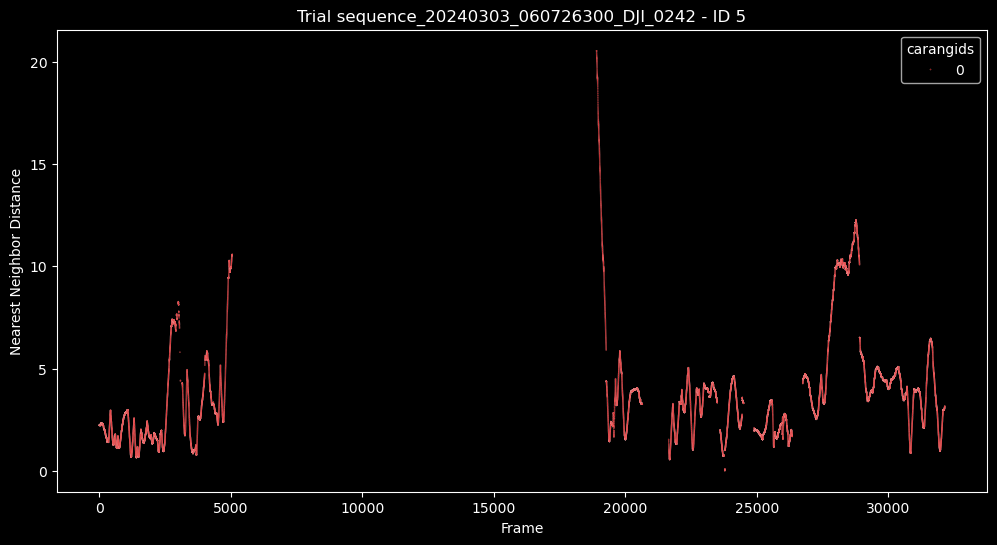

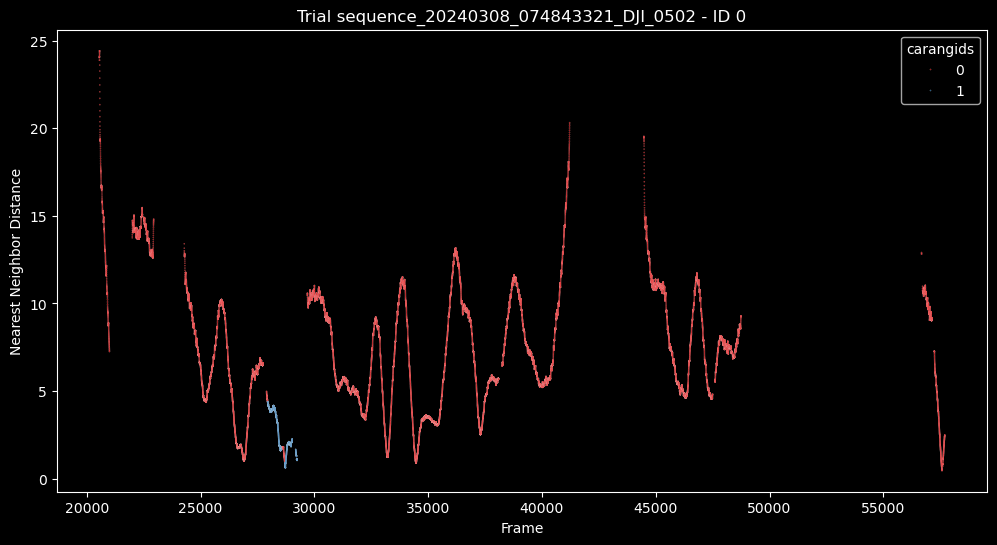

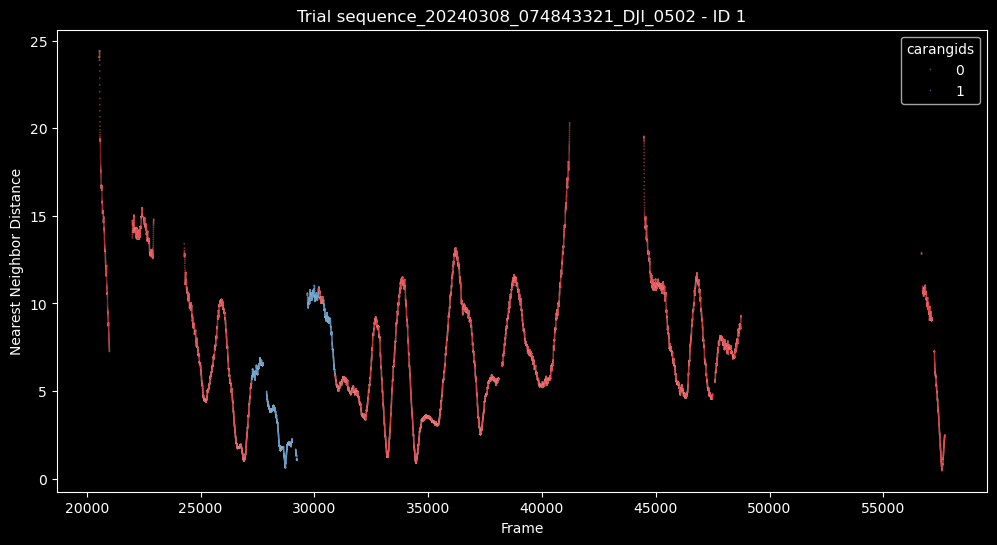

In [22]:
# Loop through each unique Trial
for trial in subset['Trial'].unique():
    trial_data = subset[subset['Trial'] == trial]  # Filter data for the current trial
    
    # Loop through each unique ID in the current trial
    for i in trial_data['ID'].unique():
        plt.figure(figsize=(12, 6))  # Create a new figure for each plot
        
        # Filter the data for the current ID and Trial
        fish_data = trial_data[trial_data['ID'] == i]
        
        # Create the scatter plot with hue based on the 'carangids' column
        sns.scatterplot(x='frame', y='normalized_nnd', data=fish_data, hue='carangids', palette="Set1", s=1, alpha=0.7)
        
        # Set the title and labels
        plt.title(f"Trial {trial} - ID {i}")
        plt.xlabel('Frame')
        plt.ylabel('Nearest Neighbor Distance')
        
        # Show the plot
        plt.show()


In [29]:
subset.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0      0         0.000000   0          NaN          NaN -0.263183      0   
1      1        55.754349   0          NaN          NaN -0.253584      1   
2      2       103.976613   0          NaN          NaN -0.245468      2   
3      3       123.176350   0          NaN          NaN -0.238684      3   
4      4       126.865948   0          NaN          NaN -0.233522      4   

   time    headx       heady  ...  ID_checked  unique_id_count  delta_time  \
0  0.00  2044.00  685.000000  ...         1.0              5.0         NaN   
1  0.01  2045.00  685.000000  ...         1.0              5.0         NaN   
2  0.02  2046.00  684.333333  ...         1.0              5.0         NaN   
3  0.03  2047.75  684.000000  ...         1.0              5.0         NaN   
4  0.04  2049.20  683.800000  ...         1.0              5.0         NaN   

   speed  body_length  standardized_speed  nearest_neighbor  nn_distance  \
0    NaN   177.037783                 NaN               2.0   127.283149   
1    NaN   177.447051                 NaN               2.0   126.931576   
2    NaN   177.425603                 NaN               2.0   126.919156   
3    NaN   177.486965                 NaN               2.0   126.385571   
4    NaN   176.966319                 NaN               2.0   125.861908   

   mean_body_length  normalized_nnd  
0        168.769768        0.754182  
1        168.968342        0.751215  
2        168.964560        0.751158  
3        169.092242        0.747436  
4        169.239818        0.743690  

[5 rows x 45 columns]

C:\Users\sophi\AppData\Local\Temp\ipykernel_2688\4176524810.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Carangid", y=metric, data=avg_df, palette=palette)
C:\Users\sophi\AppData\Local\Temp\ipykernel_2688\4176524810.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


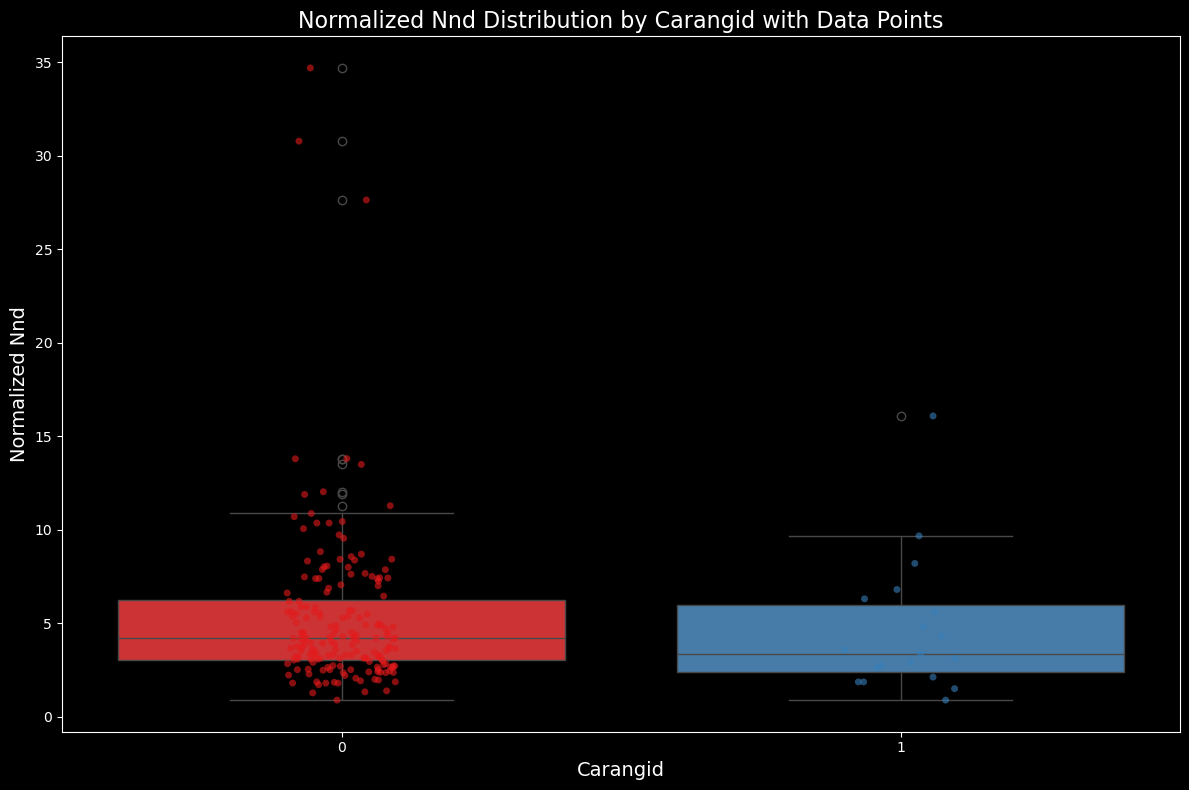

C:\Users\sophi\AppData\Local\Temp\ipykernel_2688\4176524810.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Carangid", y=metric, data=avg_df, palette=palette)
C:\Users\sophi\AppData\Local\Temp\ipykernel_2688\4176524810.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


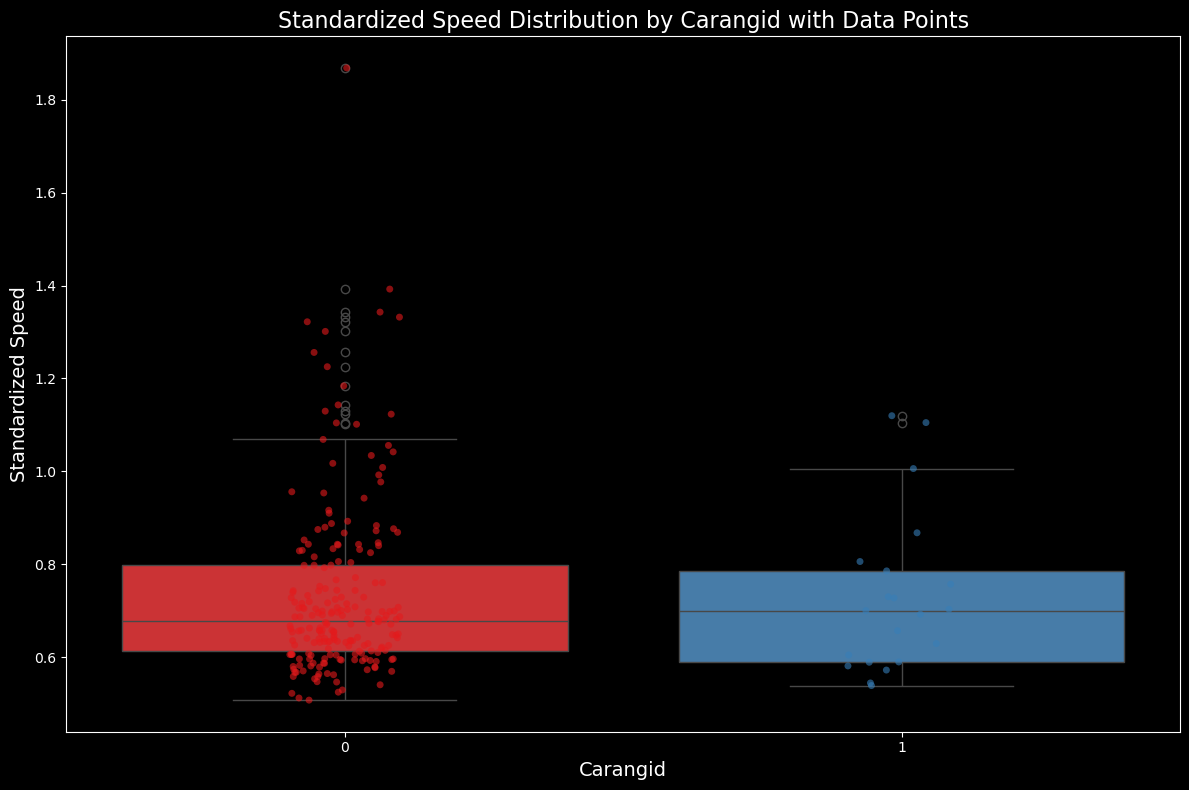

In [32]:
# Function to calculate averages for multiple metrics, grouped by tracklet within each trial
def calculate_tracklet_averages(data, metrics):
    averages = []
    
    for trial, trial_data in data.groupby('Trial'):
        for tracklet, tracklet_data in trial_data.groupby('tracklet'):  # Group by 'tracklet'
            avg_values = {metric: tracklet_data[metric].mean() for metric in metrics}  # Compute mean for metrics
            avg_values['Trial'] = trial  # Include trial info
            avg_values['Tracklet'] = tracklet  # Include tracklet info
            avg_values['Carangid'] = tracklet_data['carangids'].iloc[0]  # Preserve 'carangid' info
            averages.append(avg_values)  
    
    return pd.DataFrame(averages)

# Metrics to plot
metrics = ['normalized_nnd', 'standardized_speed']

# Calculate the averages for the metrics
avg_df = calculate_tracklet_averages(subset, metrics)  # FIXED FUNCTION NAME

# Ensure 'Carangid' is treated as a categorical variable
avg_df['Carangid'] = avg_df['Carangid'].astype('category')

# Define Seaborn Set1 color palette
palette = "Set1"

# Create plots for each metric
for metric in metrics:
    plt.figure(figsize=(12, 8))

    # Box plot for the current metric
    sns.boxplot(x="Carangid", y=metric, data=avg_df, palette=palette)

    # Overlay strip plot for individual data points
    sns.stripplot(
        x="Carangid", y=metric, data=avg_df, palette=palette, marker="o",
        alpha=0.6, jitter=True # Ensuring proper jittering
    )

    # Title and labels
    plt.title(f'{metric.replace("_", " ").title()} Distribution by Carangid with Data Points', fontsize=16)
    plt.xlabel("Carangid", fontsize=14)
    plt.ylabel(metric.replace("_", " ").title(), fontsize=14)

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()

C:\Users\sophi\AppData\Local\Temp\ipykernel_2688\2003754391.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Trial", y=metric, data=avg_df, palette=palette)
C:\Users\sophi\AppData\Local\Temp\ipykernel_2688\2003754391.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


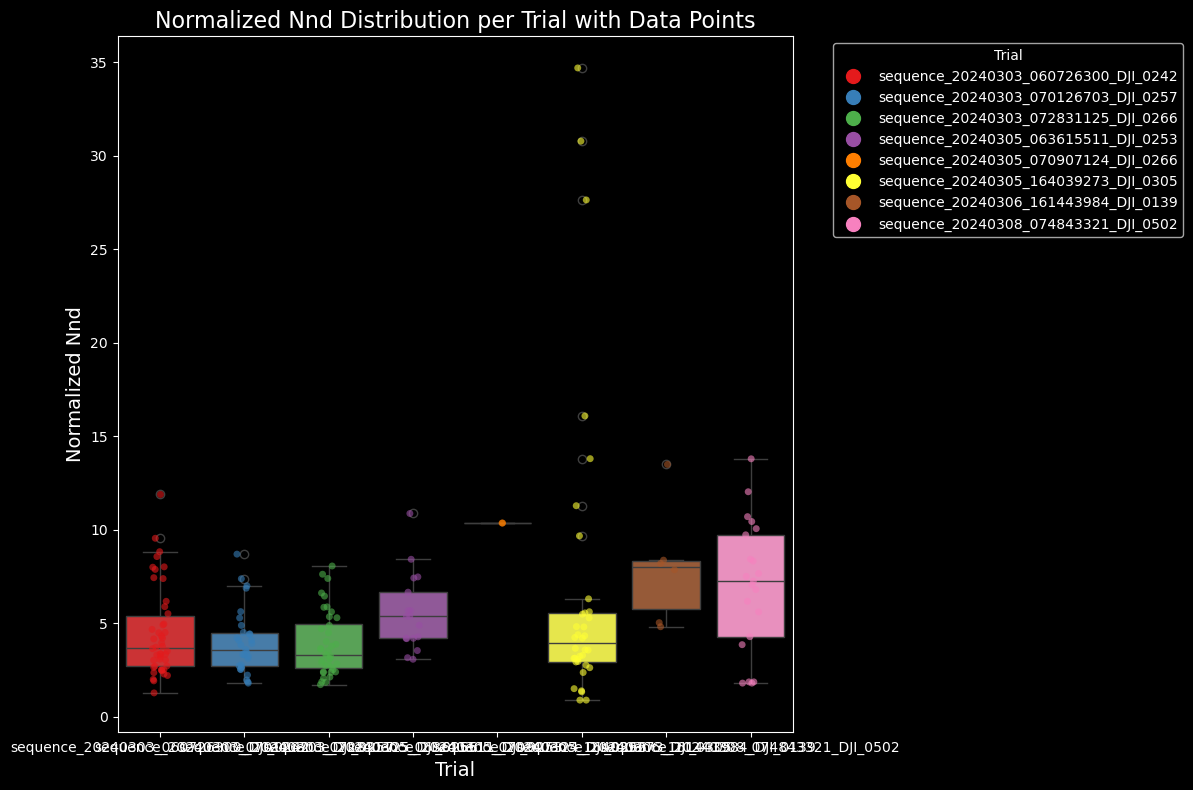

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate averages for a metric with filtering
def calculate_segment_averages(data, metric, min_count=1):
    averages = []
    trials = []
    for trial, trial_data in data.groupby('Trial'):
        for id_, id_data in trial_data.groupby('ID'):
            for segment, segment_data in id_data.groupby('segment'):  # Group by 'segment'
                if len(segment_data) >= min_count:  # Filter by minimum count
                    avg_value = segment_data[metric].mean()
                    averages.append({'Trial': trial, metric: avg_value})  # Append trial and average value
    return pd.DataFrame(averages)

# Metric to plot
metric = 'normalized_nnd'

# Calculate the averages for the given metric
avg_df = calculate_segment_averages(subset, metric)

# Create the plot
plt.figure(figsize=(12, 8))

# Generate unique colors for each Trial
palette = sns.color_palette("Set1", n_colors=avg_df['Trial'].nunique())

# Box plot for the metric
sns.boxplot(x="Trial", y=metric, data=avg_df, palette=palette)

# Overlay strip plot for data points with the same palette
sns.stripplot(
    x="Trial", y=metric, data=avg_df, palette=palette, marker="o", alpha=0.6, jitter=True
)

# Add legend using unique Trial names
handles = [
    plt.Line2D([0], [0], marker='o', color=palette[i], linestyle='', markersize=10, label=trial)
    for i, trial in enumerate(avg_df['Trial'].unique())
]
plt.legend(handles=handles, title='Trial', bbox_to_anchor=(1.05, 1), loc='upper left')

# Title and labels
plt.title(f'{metric.replace("_", " ").title()} Distribution per Trial with Data Points', fontsize=16)
plt.xlabel("Trial", fontsize=14)
plt.ylabel(metric.replace("_", " ").title(), fontsize=14)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(figures_path +'plotnnd1.png')
plt.show()


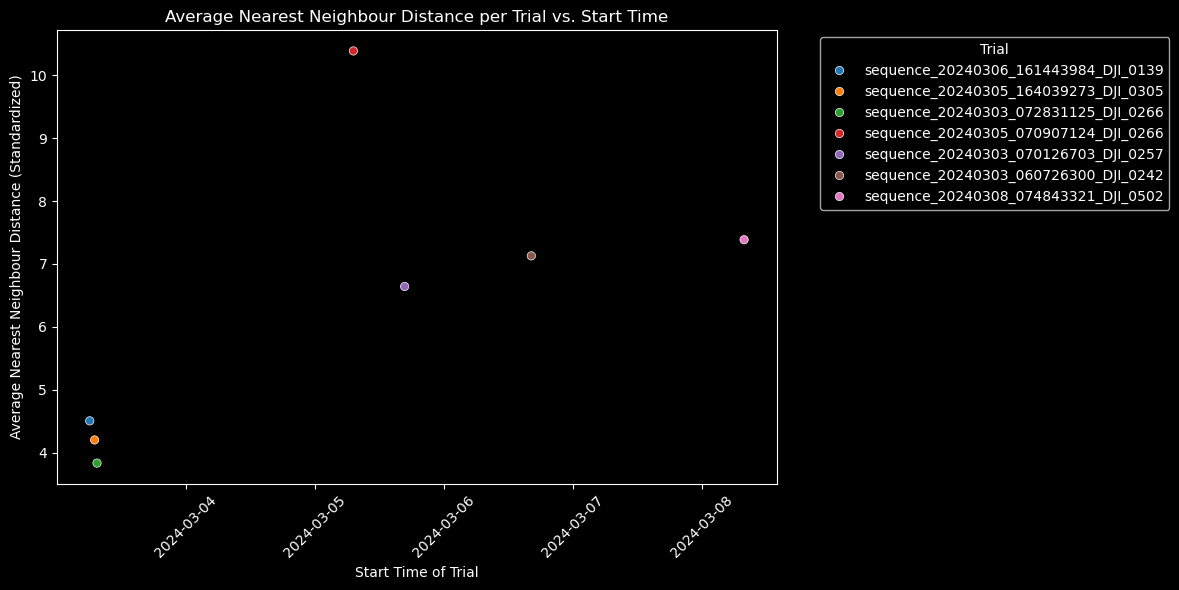

In [24]:
# Function to parse start time from the trial name
def parse_start_time(trial_name):
    date_part = trial_name.split('_')[1]
    time_part = trial_name.split('_')[2]
    # Combine date and time, ensuring correct format
    datetime_str = f"{date_part}{time_part[:6]}{time_part[6:]}"  # YYYYMMDDHHMMSSsss
    return datetime.strptime(datetime_str, '%Y%m%d%H%M%S%f')

# Calculate average NND for each trial
average_nnds = []
trial_start_times = []

for trial, trial_data in subset.groupby('Trial'):
    avg_nnd = trial_data['normalized_nnd'].mean()  # Compute the average NND for the trial
    start_time = parse_start_time(trial)  # Get the start time of the trial
    average_nnds.append(avg_nnd)
    trial_start_times.append(start_time)

# Create a DataFrame for the average NNDs and start times
avg_nnd_df = pd.DataFrame({
    'Trial': subset['Trial'].unique(),
    'avg_nnd': average_nnds,
    'start_time': trial_start_times
})

# Plot the data using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=avg_nnd_df, 
    x='start_time', 
    y='avg_nnd', 
    hue='Trial',  # Add hue for the trial
    palette='tab10'
)

# Add labels and title
plt.xlabel('Start Time of Trial')
plt.ylabel('Average Nearest Neighbour Distance (Standardized)')
plt.title('Average Nearest Neighbour Distance per Trial vs. Start Time')
plt.legend(title='Trial', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

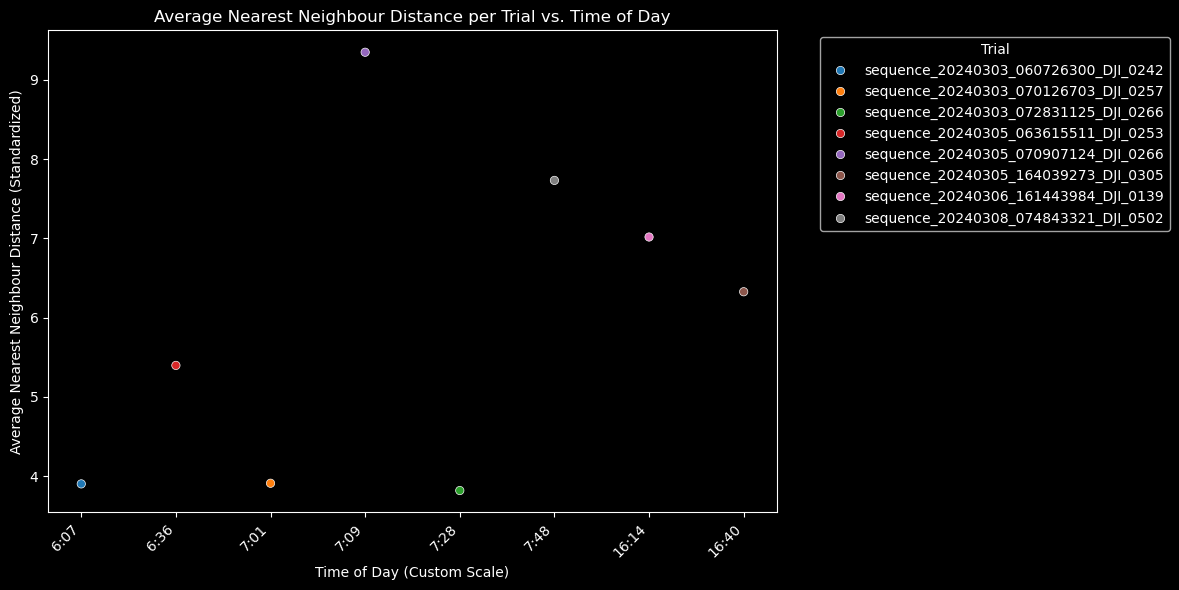

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to parse the time of day from the trial name
def parse_start_time(trial_name):
    time_part = trial_name.split('_')[2]  # Extract the time from the trial name (HHMMSSsss)
    time_str = f"{time_part[:2]}:{time_part[2:4]}:{time_part[4:6]}.{time_part[6:]}"  # Format time
    return datetime.strptime(time_str, '%H:%M:%S.%f').time()  # Convert to time object

# Convert time to seconds since midnight
def time_to_seconds(time_obj):
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1e6

# Calculate average nearest neighbor distance for each trial
average_nnds = []
trial_start_times = []

for trial, trial_data in subset.groupby('Trial'):
    avg_nnd = trial_data['normalized_nnd'].mean()  # Compute the average nearest neighbor distance for the trial
    start_time = parse_start_time(trial)  # Get the start time of the trial (time of day)
    average_nnds.append(avg_nnd)
    trial_start_times.append(start_time)

# Create a DataFrame for the average distances and start times
avg_nnd_df = pd.DataFrame({
    'Trial': list(subset['Trial'].unique()),  # Convert to list for consistent ordering
    'avg_nnd': average_nnds,
    'start_time': trial_start_times
})

# Convert start time to seconds for plotting
avg_nnd_df['start_time_seconds'] = avg_nnd_df['start_time'].apply(time_to_seconds)

# Custom mapping: Re-scale time
valid_seconds = avg_nnd_df['start_time_seconds'].sort_values().unique()
custom_x_mapping = {v: i for i, v in enumerate(valid_seconds)}
avg_nnd_df['custom_x'] = avg_nnd_df['start_time_seconds'].map(custom_x_mapping)

# Plot the data using seaborn
plt.figure(figsize=(12, 6))

# Scatter plot with the custom x-axis
sns.scatterplot(
    data=avg_nnd_df, 
    x='custom_x', 
    y='avg_nnd', 
    hue='Trial', 
    palette='tab10'
)

# Add labels and title
plt.xlabel('Time of Day (Custom Scale)')
plt.ylabel('Average Nearest Neighbour Distance (Standardized)')
plt.title('Average Nearest Neighbour Distance per Trial vs. Time of Day')
plt.legend(title='Trial', bbox_to_anchor=(1.05, 1), loc='upper left')

# Format the x-axis labels with original time
plt.xticks(
    ticks=range(len(valid_seconds)), 
    labels=[str(timedelta(seconds=int(t)))[:-3] for t in valid_seconds], 
    rotation=45, ha='right'
)

plt.tight_layout()
plt.show()



#### Averages

In [6]:
subset = pd.read_hdf(output_folder + "nn_sharks.h5", key='sharks')

In [7]:
subset['Trial_num']= subset['Trial'].astype('category').cat.codes

In [22]:
nn_distance_avg = subset[['carangids','normalized_nnd','Trial_num']].groupby(['carangids','Trial_num']).mean().reset_index()
nn_distance_avg

carangids  Trial_num  normalized_nnd
0           0          0        4.021547
1           0          1        4.338875
2           0          2        3.814215
3           0          3        5.405684
4           0          4       10.361224
5           0          5        6.569510
6           0          6        6.943756
7           0          7        7.571537
8           1          0        2.897584
9           1          1        2.452343
10          1          2        3.481356
11          1          5        5.219402
12          1          6        7.047693
13          1          7        5.121927

In [23]:
nn_distance_avgID = subset[['carangids','normalized_nnd','Trial_num', 'ID']].groupby(['carangids','Trial_num', 'ID']).mean().reset_index()
nn_distance_avgID

carangids  Trial_num  ID  normalized_nnd
0           0          0   0        3.800286
1           0          0   1        4.314520
2           0          0   2        3.782741
3           0          0   3        4.961696
4           0          0   4        3.644205
5           0          0   5        3.473005
6           0          1   0        4.675370
7           0          1   1        4.658044
8           0          1   2        2.666168
9           0          1   3        4.237209
10          0          2   0        3.679679
11          0          2   1        3.702293
12          0          2   2        3.869792
13          0          2   3        4.013532
14          0          3   0        5.741712
15          0          3   1        4.763683
16          0          3   2        6.132237
17          0          4   0       10.361224
18          0          4   1       10.361224
19          0          5   0        6.062325
20          0          5   1        8.732349
21          0          5   2        4.747116
22          0          6   0        6.140393
23          0          6   1        7.180308
24          0          7   0        7.581590
25          0          7   1        7.560642
26          1          0   0        2.818729
27          1          0   1        3.676613
28          1          0   2        1.883397
29          1          0   4        1.638237
30          1          1   0        2.316834
31          1          1   1        2.574417
32          1          1   2        2.305608
33          1          1   3        2.718499
34          1          2   1        2.733643
35          1          2   2        3.611991
36          1          2   3        3.264931
37          1          5   0        5.680057
38          1          5   1        5.869403
39          1          5   2        4.448034
40          1          6   0        7.315529
41          1          6   1        2.142714
42          1          7   0        2.788322
43          1          7   1        5.979059

In [8]:
nndistanceavg = subset[['carangids','normalized_nnd','Trial_num', 'tracklet']].groupby(['carangids','Trial_num', 'tracklet']).mean().reset_index()

In [13]:

print("GroupBy row count:", len(nndistanceavg))

GroupBy row count: 287


C:\Users\sophi\AppData\Local\Temp\ipykernel_5668\1989571691.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='carangids',y='normalized_nnd',data = nndistanceavg, palette="Set1")


<Axes: xlabel='carangids', ylabel='normalized_nnd'>

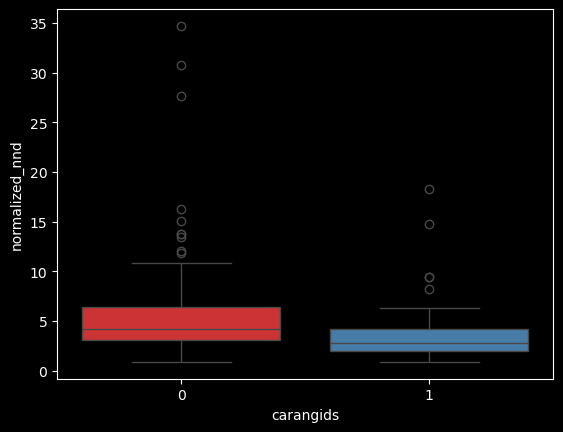

In [9]:
sns.boxplot(x='carangids',y='normalized_nnd',data = nndistanceavg, palette="Set1")

In [10]:
nndID = subset[['unique_id_count','normalized_nnd','Trial_num','ID','segment']].groupby(['unique_id_count','Trial_num','ID', 'segment']).mean().reset_index()

C:\Users\sophi\AppData\Local\Temp\ipykernel_5668\1705780198.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unique_id_count',y='normalized_nnd',data = nndID, palette='Set1')
C:\Users\sophi\AppData\Local\Temp\ipykernel_5668\1705780198.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="unique_id_count", y='normalized_nnd', data=nndID, palette='Set1', marker="o", alpha=0.6, jitter=True)


<Axes: xlabel='unique_id_count', ylabel='normalized_nnd'>

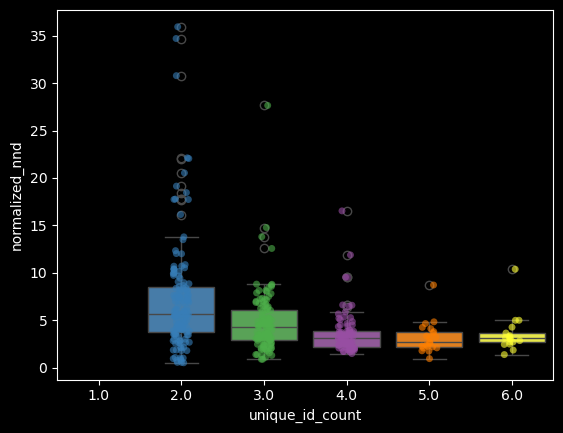

In [11]:
nndID = subset[['unique_id_count','normalized_nnd','Trial_num','ID','segment']].groupby(['unique_id_count','Trial_num','ID', 'segment']).mean().reset_index()
sns.boxplot(x='unique_id_count',y='normalized_nnd',data = nndID, palette='Set1')
# Overlay strip plot for data points with the same palette
sns.stripplot(x="unique_id_count", y='normalized_nnd', data=nndID, palette='Set1', marker="o", alpha=0.6, jitter=True)

C:\Users\sophi\AppData\Local\Temp\ipykernel_5668\1323638412.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unique_id_count',y='standardized_speed',data = speedtracklet, palette='Set1')
C:\Users\sophi\AppData\Local\Temp\ipykernel_5668\1323638412.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="unique_id_count", y='standardized_speed', data=speedtracklet, palette='Set1', marker="o", alpha=0.6, jitter=True)


<Axes: xlabel='unique_id_count', ylabel='standardized_speed'>

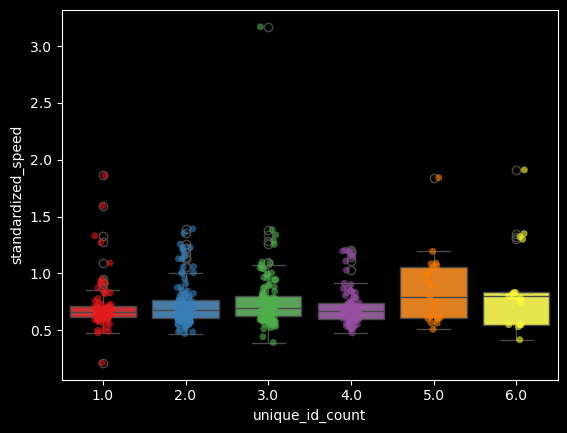

In [12]:
speedtracklet = subset[['unique_id_count','standardized_speed','Trial_num','ID','tracklet']].groupby(['unique_id_count','Trial_num','ID','tracklet']).mean().reset_index()
sns.boxplot(x='unique_id_count',y='standardized_speed',data = speedtracklet, palette='Set1')
# Overlay strip plot for data points with the same palette
sns.stripplot(x="unique_id_count", y='standardized_speed', data=speedtracklet, palette='Set1', marker="o", alpha=0.6, jitter=True)

### Logistic Regression

In [17]:
df = pd.read_hdf(output_folder + "nn_sharks.h5", key='sharks')
df.head()

index  SPEED#wcentroid  ID  X#pcentroid  Y#pcentroid     ANGLE  frame  \
0   2051        82.087409   0   606.844014  -396.939687 -0.435146   2051   
1   2052        76.964699   0   608.723694  -396.273295 -0.456252   2052   
2   2053        75.903308   0   610.451965  -395.569743 -0.479337   2053   
3   2054        71.775297   0   612.184855  -394.984894 -0.500498   2054   
4   2055        81.043147   0   613.870341  -394.378459 -0.521608   2055   

    time        headx        heady  ...  drone_movement  ID_checked  \
0  40.91  3172.583333  1069.333333  ...               0         1.0   
1  40.93  3174.333333  1068.916667  ...               0         1.0   
2  40.95  3175.916667  1068.416667  ...               0         1.0   
3  40.97  3177.416667  1067.916667  ...               0         1.0   
4  40.99  3178.833333  1067.500000  ...               0         1.0   

   delta_time  speed  smoothed_body_length  standardized_speed  \
0         NaN    NaN            109.851996                 NaN   
1         NaN    NaN            110.187803                 NaN   
2         NaN    NaN            110.539454                 NaN   
3         NaN    NaN            110.882277                 NaN   
4         NaN    NaN            111.196668                 NaN   

   nearest_neighbor  nn_distance  mean_body_length  normalized_nnd  
0                 1   696.033544        108.149438        6.435850  
1                 1   698.254526        108.313050        6.446633  
2                 1   700.389238        108.468860        6.457054  
3                 1   702.533543        108.648260        6.466128  
4                 1   704.553259        108.808531        6.475166  

[5 rows x 43 columns]

(array([4.21775e+05, 1.38736e+05, 2.81630e+04, 8.53400e+03, 2.31500e+03,
        2.16400e+03, 2.21300e+03, 1.54100e+03, 5.08000e+02, 7.40000e+01]),
 array([5.38896508e-03, 5.57815313e+00, 1.11509173e+01, 1.67236814e+01,
        2.22964456e+01, 2.78692098e+01, 3.34419739e+01, 3.90147381e+01,
        4.45875023e+01, 5.01602664e+01, 5.57330306e+01]),
 <BarContainer object of 10 artists>)

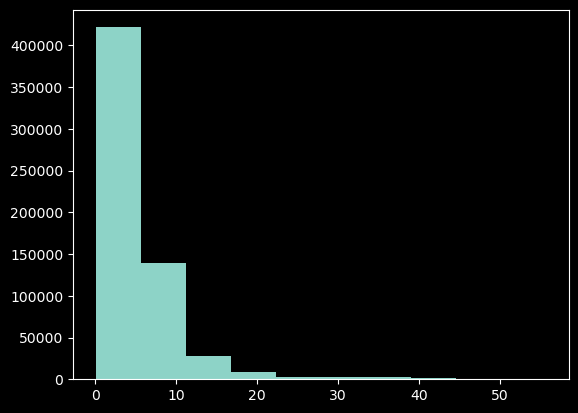

In [18]:
plt.hist(df['normalized_nnd'])

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()
df['normalized_nnd_scaled']=scaler.fit_transform(df[['normalized_nnd']])

(array([4.21775e+05, 1.38736e+05, 2.81630e+04, 8.53400e+03, 2.31500e+03,
        2.16400e+03, 2.21300e+03, 1.54100e+03, 5.08000e+02, 7.40000e+01]),
 array([-1.01499884,  0.08919275,  1.19338434,  2.29757593,  3.40176752,
         4.50595911,  5.6101507 ,  6.71434229,  7.81853388,  8.92272547,
        10.02691706]),
 <BarContainer object of 10 artists>)

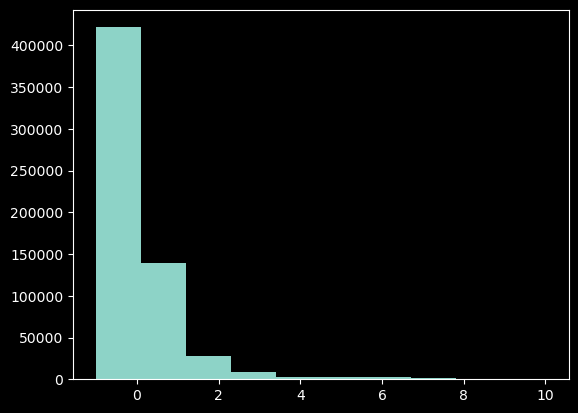

In [21]:
plt.hist(df['normalized_nnd_scaled'])

In [13]:
# Group by both 'ID' and 'segment' and count the number of frames for each group
id_segment_counts = df.groupby(['ID', 'segment','Trial']).size()

# Filter out ID-segment combinations that have less than 100 frames (2 seconds)
id_segments_to_keep = id_segment_counts[id_segment_counts >= 200].index

# Keep only the rows where the combination of 'ID' and 'segment' is in the list of groups with >= 100 frames
df_filtered = df[df.set_index(['ID', 'segment','Trial']).index.isin(id_segments_to_keep)]

#### segments

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset (assuming df is your DataFrame)
df = df.copy()

# Ensure relevant columns are present
relevant_columns = ['ID', 'frame', 'headx', 'heady', 'lxfinx', 'lxfiny', 'btipx', 'btipy', 
                    'rxfinx', 'rxfiny', 'pelvicfinx', 'pelvicfiny', 'sdfinx', 'sdfiny',
                    'pedunclex', 'peduncley', 'finx', 'finy', 'ttipx', 'ttipy', 
                    'segment', 'Trial', 'midpoint_x', 'midpoint_y', 'normalized_nnd']

df = df[relevant_columns].dropna()  # Remove NaNs

# ✅ Create movement-based features (frame differences)
for col in ['headx', 'heady', 'lxfinx', 'lxfiny', 'btipx', 'btipy', 'rxfinx', 'rxfiny', 
            'pelvicfinx', 'pelvicfiny', 'sdfinx', 'sdfiny', 'pedunclex', 'peduncley', 
            'finx', 'finy', 'ttipx', 'ttipy', 'midpoint_x', 'midpoint_y', 'normalized_nnd']:
    df[f"{col}_diff"] = df[col] - df[col].shift(1)

# ✅ Labeling (Same Segment = 1, Random = 0)
df['same_segment'] = (df['segment'] == df['segment'].shift(1)).astype(int)

# Remove NaNs from shift operation
df = df.dropna()

# Define features & target
feature_columns = [col for col in df.columns if '_diff' in col]  # Only movement-based features
X = df[feature_columns]
y = df['same_segment']

# ✅ Split data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# ✅ Make Predictions
y_pred = model.predict(X_test)

# ✅ Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)


Accuracy: 0.9988
Confusion Matrix:
 [[     0    149]
 [     0 121049]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       1.00      1.00      1.00    121049

    accuracy                           1.00    121198
   macro avg       0.50      0.50      0.50    121198
weighted avg       1.00      1.00      1.00    121198



C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

#### with carangids

Epoch 1/10


C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 56s 9s/step - accuracy: 0.7938 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.7707 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.7804 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 54s 9s/step - accuracy: 0.7747 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - accuracy: 0.7603 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 57s 9s/step - accuracy: 0.7888 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - accuracy: 0.7758 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 56s 9s/step - accuracy: 0.7681 - loss: nan - val_accuracy: 0.7556 - val_loss: nan
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - accuracy: 0.7621 

C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

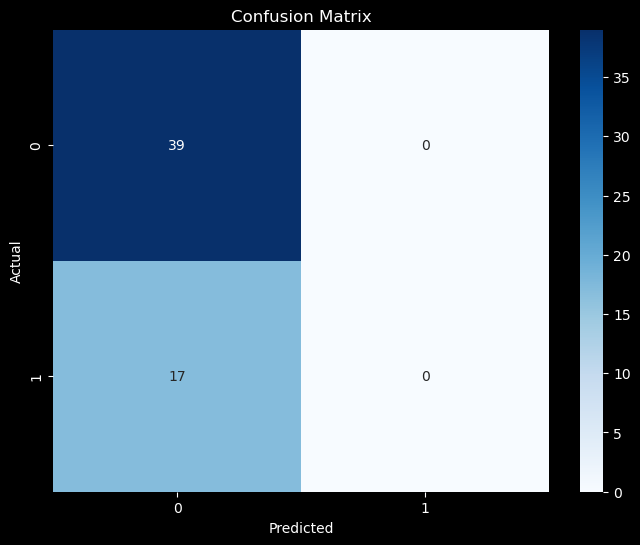

C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'TimeDistributed' is not defined

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Create time-series data
sequence_data = []
targets = []

for trial_id, trial_df in df_filtered.groupby(['ID', 'Trial', 'segment', 'carangids']):
    speeds = trial_df['normalized_nnd'].values
    target = trial_df['carangids'].iloc[0]  # Assuming target is consistent per trial
    sequence_data.append(speeds)
    targets.append(target)

# Padding sequences to ensure uniform length
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(seq) for seq in sequence_data)
X = pad_sequences(sequence_data, maxlen=max_len, padding='post', dtype='float32')
y = np.array(targets)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, 1)),  # Handle padded values
    LSTM(50, activation='tanh', return_sequences=False),  # Adjust units as needed
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example: Create time-series data
sequence_data = []
targets = []

for trial_id, trial_df in df_filtered.groupby(['ID', 'Trial', 'segment', 'carangids']):
    speeds = trial_df['normalized_nnd'].values
    target_sequence = trial_df['carangids'].values  # Full target sequence
    sequence_data.append(speeds)
    targets.append(target_sequence)

# Padding sequences for both inputs and outputs
max_len = max(len(seq) for seq in sequence_data)
X = pad_sequences(sequence_data, maxlen=max_len, padding='post', dtype='float32')
y = pad_sequences(targets, maxlen=max_len, padding='post', dtype='int')  # Ensure binary targets are padded

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Build LSTM Model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, 1)),  # Handle padded values
    LSTM(50, activation='tanh', return_sequences=True),  # Return sequences for multi-frame output
    TimeDistributed(Dense(1, activation='sigmoid'))  # Predict binary output for each frame
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Flatten the outputs for evaluation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred_flat))

# Confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
